In [4]:
import xarray as xr

# Import all datasets in .nc format
dataset_ETA = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_ETA.nc')    # Load Evapotranspiration dataset
dataset_LST = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_LST.nc')    # Load Land Surface Temperature dataset
dataset_NDVI = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_NDVI.nc')  # Load Normalized Difference Vegetation Index dataset
dataset_Pre = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_Pre.nc')    # Load Precipitation dataset
dataset_SM = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_SM.nc')      # Load Soil Moisture dataset
dataset_Tmax = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_Tmax.nc')  # Load Maximum Temperature dataset
dataset_Tmin = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_Tmin.nc')  # Load Minimum Temperature dataset

In [19]:
dataset_LST

<xarray.Dataset> Size: 257MB
Dimensions:    (time: 287, latitude: 347, longitude: 322)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2023-12-31
  * latitude   (latitude) float64 3kB 33.0 32.99 32.98 32.97 ... 29.9 29.9 29.89
  * longitude  (longitude) float64 3kB 47.66 47.67 47.68 ... 50.53 50.54 50.55
Data variables:
    value      (time, latitude, longitude) float64 257MB nan nan nan ... nan nan

In [30]:
import rasterio
import xarray as xr
import numpy as np

# File path to your DEM file
file_path = "H:\LST_KH\Code_Github\dem1.tif"  # Replace with your actual file path

# Read the DEM data
with rasterio.open(file_path) as src:
    dem_data = src.read(1)  # Read the first band
    dem_transform = src.transform  # Transformation matrix for georeferencing
    dem_crs = src.crs  # Coordinate reference system
    dem_width = src.width
    dem_height = src.height
    dem_bounds = src.bounds  # Bounding box (left, bottom, right, top)

# Convert to xarray.DataArray
dem = xr.DataArray(
    dem_data,
    dims=["lat", "lon"],  # Dimension names
    coords={
        "lat": np.linspace(dem_bounds[1], dem_bounds[3], dem_height),  # Latitude
        "lon": np.linspace(dem_bounds[0], dem_bounds[2], dem_width),  # Longitude
    },
    attrs={
        "crs": dem_crs,
        "transform": dem_transform,
        "description": "Digital Elevation Model (DEM)",
    }
)

# Print DataArray details
print(dem)


<xarray.DataArray (lat: 347, lon: 322)> Size: 223kB
array([[32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       ...,
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767]], dtype=int16)
Coordinates:
  * lat      (lat) float64 3kB 29.88 29.89 29.9 29.9 ... 32.97 32.98 32.99 32.99
  * lon      (lon) float64 3kB 47.67 47.68 47.68 47.69 ... 50.54 50.55 50.56
Attributes:
    crs:          EPSG:4326
    transform:    | 0.01, 0.00, 47.67|\n| 0.00,-0.01, 32.99|\n| 0.00, 0.00, 1...
    description:  Digital Elevation Model (DEM)


In [27]:
import xarray as xr
import pandas as pd
import numpy as np
import rasterio

# Import all datasets in .nc format
dataset_ETA = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_ETA.nc')    # Load Evapotranspiration dataset
dataset_LST = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_LST.nc')    # Load Land Surface Temperature dataset
dataset_NDVI = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_NDVI.nc')  # Load Normalized Difference Vegetation Index dataset
dataset_Pre = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_Pre.nc')    # Load Precipitation dataset
dataset_SM = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_SM.nc')      # Load Soil Moisture dataset
dataset_Tmax = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_Tmax.nc')  # Load Maximum Temperature dataset
dataset_Tmin = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_Tmin.nc')  # Load Minimum Temperature dataset

# Select data for years 2001 to 2023
years = slice("2001-01-01", "2023-12-31")

# Function to extract time-averaged data
def extract_data(dataset, variable_name):
    dataset = dataset.sel(time=years)  # Select years
    mean_data = dataset[variable_name].mean(dim='time')  # Time-averaged DataArray
    return mean_data

# Extract time-averaged data
mean_LST = extract_data(dataset_LST, "value")
mean_Pre = extract_data(dataset_Pre, "value")
mean_Tmin = extract_data(dataset_Tmin, "value")
mean_Tmax = extract_data(dataset_Tmax, "value")
mean_SM = extract_data(dataset_SM, "value")
mean_NDVI = extract_data(dataset_NDVI, "value")
mean_ETA = extract_data(dataset_ETA, "value")

# Create meshgrid for coordinates (use 'latitude' and 'longitude')
lat_values = mean_LST.latitude.values
lon_values = mean_LST.longitude.values
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)

# Create DataFrame
data = pd.DataFrame({
    "Lat": lat_grid.flatten(),
    "Lon": lon_grid.flatten(),
    "LST": mean_LST.values.flatten(),
    "Precipitation": mean_Pre.values.flatten(),
    "Tmin": mean_Tmin.values.flatten(),
    "Tmax": mean_Tmax.values.flatten(),
    "Soil_Moisture": mean_SM.values.flatten(),
    "NDVI": mean_NDVI.values.flatten(),
    "ETA": mean_ETA.values.flatten(),
})

# Drop rows with NaN values
data = data.dropna()

# Load DEM
file_path = "H:\\LST_KH\\Code_Github\\dem1.tif"
with rasterio.open(file_path) as src:
    dem_data = src.read(1)
    dem_transform = src.transform
    dem_crs = src.crs
    dem_width = src.width
    dem_height = src.height
    dem_bounds = src.bounds

dem = xr.DataArray(
    dem_data,
    dims=["lat", "lon"],
    coords={
        "lat": np.linspace(dem_bounds[1], dem_bounds[3], dem_height),
        "lon": np.linspace(dem_bounds[0], dem_bounds[2], dem_width),
    },
    attrs={"crs": dem_crs, "transform": dem_transform, "description": "DEM"}
)

# Mask nodata values (assuming 32767 is nodata)
dem = dem.where(dem != 32767, np.nan)

# Align DEM with NetCDF coordinates
dem = dem.rename({"lat": "latitude", "lon": "longitude"})  # Rename for consistency
dem = dem.interp(latitude=mean_LST.latitude, longitude=mean_LST.longitude, method="nearest")

# Create dem_df
lon_grid, lat_grid = np.meshgrid(dem.longitude.values, dem.latitude.values)
dem_df = pd.DataFrame({
    "Lat": lat_grid.flatten(),
    "Lon": lon_grid.flatten(),
    "DEM": dem.values.flatten()
})

# Round coordinates to avoid precision issues
data["Lat"] = data["Lat"].round(6)
data["Lon"] = data["Lon"].round(6)
dem_df["Lat"] = dem_df["Lat"].round(6)
dem_df["Lon"] = dem_df["Lon"].round(6)

# Merge data with dem_df
data = pd.merge(data, dem_df, how="left", on=["Lat", "Lon"])

# Check result
print(data.head())

        Lat        Lon        LST  Precipitation       Tmin       Tmax  \
0  32.99512  48.257497  27.302913      28.890638  16.620691  31.845066   
1  32.99512  48.266480  26.953724      29.694431  16.424173  31.652737   
2  32.99512  48.275463  26.090019      30.966520  16.016800  31.234159   
3  32.99512  48.284447  24.669044      30.794178  16.016800  31.234159   
4  32.99512  48.293430  23.739588      30.801811  16.016800  31.234159   

   Soil_Moisture      NDVI        ETA  DEM  
0      13.392310  0.256926  22.343081  NaN  
1      13.479115  0.269564  22.457006  NaN  
2      13.644348  0.261495  21.879297  NaN  
3      13.644348  0.238849  21.879297  NaN  
4      13.644348  0.194785  21.879297  NaN  


In [28]:
data

Lat        Lon        LST  Precipitation       Tmin       Tmax  \
0      32.995120  48.257497  27.302913      28.890638  16.620691  31.845066   
1      32.995120  48.266480  26.953724      29.694431  16.424173  31.652737   
2      32.995120  48.275463  26.090019      30.966520  16.016800  31.234159   
3      32.995120  48.284447  24.669044      30.794178  16.016800  31.234159   
4      32.995120  48.293430  23.739588      30.801811  16.016800  31.234159   
...          ...        ...        ...            ...        ...        ...   
75186  29.958815  48.652756  32.650612      21.457664  18.721203  33.459545   
75187  29.958815  48.661739  32.801460      21.457664  18.721203  33.459545   
75188  29.949832  48.616823  27.932005      20.817053  18.718470  33.460861   
75189  29.949832  48.625806  28.212994      20.817053  18.718470  33.460861   
75190  29.949832  48.634789  28.652075      21.801748  18.718470  33.460861   

       Soil_Moisture      NDVI        ETA     DEM  
0          13.392310  0.256926  22.343081     NaN  
1          13.479115  0.269564  22.457006     NaN  
2          13.644348  0.261495  21.879297     NaN  
3          13.644348  0.238849  21.879297     NaN  
4          13.644348  0.194785  21.879297     NaN  
...              ...       ...        ...     ...  
75186       6.747653  0.083918  17.031143  1239.0  
75187       6.747653  0.079535  17.031143  1243.0  
75188       6.740542  0.206721  17.063046  1984.0  
75189       6.740542  0.231654  17.063046  1741.0  
75190       6.740542  0.241210  17.063046  1551.0  

[75191 rows x 10 columns]

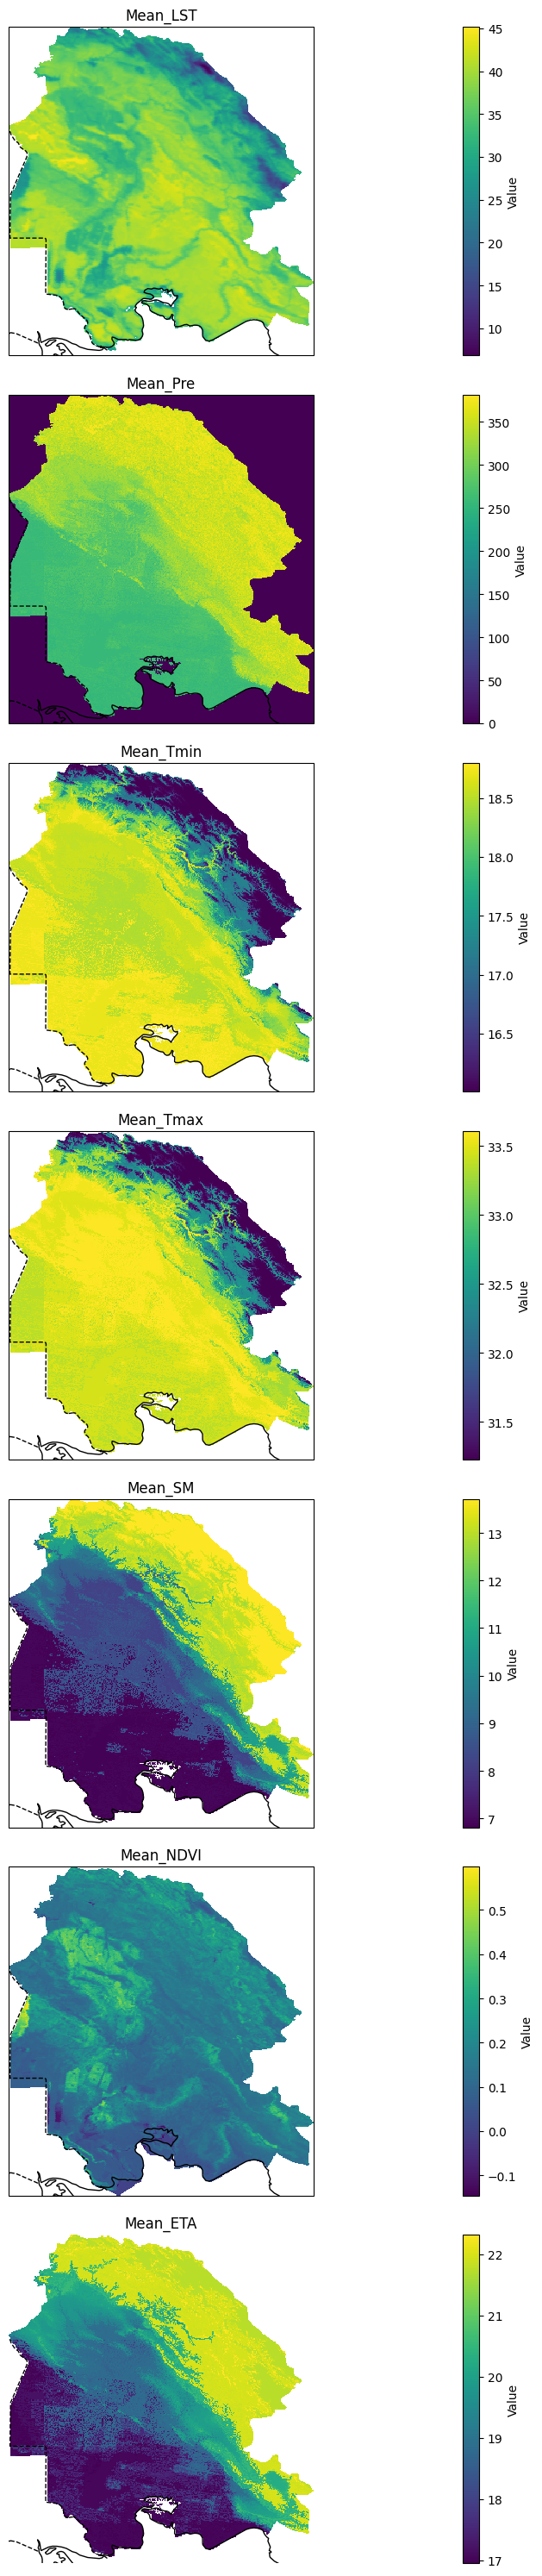

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Prepare data and titles
datasets = [
    ('Mean_LST', Mean_LST),
    ('Mean_Pre', Mean_Pre),
    ('Mean_Tmin', Mean_Tmin),
    ('Mean_Tmax', Mean_Tmax),
    ('Mean_SM', Mean_SM),
    ('Mean_NDVI', Mean_NDVI),
    ('Mean_ETA', Mean_ETA)
]

# Set up the figure and axes
fig, axes = plt.subplots(7, 1, figsize=(35, 30), subplot_kw={'projection': ccrs.PlateCarree()})

# Flatten axes for easier indexing
axes = axes.ravel()

# Loop over datasets and plot them
for i, (name, data) in enumerate(datasets):
    ax = axes[i]
    im = ax.pcolormesh(
        data['longitude'], 
        data['latitude'], 
        data, 
        transform=ccrs.PlateCarree(), 
        cmap='viridis'
    )
    ax.add_feature(cfeature.BORDERS, linestyle='--', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.set_title(name)
    fig.colorbar(im, ax=ax, orientation='vertical', label='Value')

# Turn off the last empty subplot
axes[-1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [7]:
import rasterio
from rasterio.transform import from_origin
import numpy as np
import os

# Create folder for output files
output_folder = "mean Variables"
os.makedirs(output_folder, exist_ok=True)

# Prepare data and titles
datasets = [
    ('Mean_LST', Mean_LST),
    ('Mean_Pre', Mean_Pre),
    ('Mean_Tmin', Mean_Tmin),
    ('Mean_Tmax', Mean_Tmax),
    ('Mean_SM', Mean_SM),
    ('Mean_NDVI', Mean_NDVI),
    ('Mean_ETA', Mean_ETA)
]

# Define spatial information (adjust as per your dataset)
lon = Mean_LST['longitude']  # Replace with actual longitude array
lat = Mean_LST['latitude']   # Replace with actual latitude array
pixel_size_x = lon[1] - lon[0]
pixel_size_y = lat[1] - lat[0]
transform = from_origin(lon.min(), lat.max(), pixel_size_x, abs(pixel_size_y))

# Loop over datasets to save each as GeoTIFF
for name, data in datasets:
    output_filename = os.path.join(output_folder, f"{name}.tif")
    
    # Prepare the data (convert to numpy array if necessary)
    data_array = np.array(data)
    
    # Save as GeoTIFF
    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=data_array.shape[0],
        width=data_array.shape[1],
        count=1,
        dtype=data_array.dtype,
        crs="EPSG:4326",  # Adjust CRS if different
        transform=transform,
    ) as dst:
        dst.write(data_array, 1)
    
    print(f"Saved {name} as {output_filename}")


Saved Mean_LST as mean Variables\Mean_LST.tif
Saved Mean_Pre as mean Variables\Mean_Pre.tif
Saved Mean_Tmin as mean Variables\Mean_Tmin.tif
Saved Mean_Tmax as mean Variables\Mean_Tmax.tif
Saved Mean_SM as mean Variables\Mean_SM.tif
Saved Mean_NDVI as mean Variables\Mean_NDVI.tif
Saved Mean_ETA as mean Variables\Mean_ETA.tif


In [29]:
data

Lat        Lon        LST  Precipitation       Tmin       Tmax  \
0      32.995120  48.257497  27.302913      28.890638  16.620691  31.845066   
1      32.995120  48.266480  26.953724      29.694431  16.424173  31.652737   
2      32.995120  48.275463  26.090019      30.966520  16.016800  31.234159   
3      32.995120  48.284447  24.669044      30.794178  16.016800  31.234159   
4      32.995120  48.293430  23.739588      30.801811  16.016800  31.234159   
...          ...        ...        ...            ...        ...        ...   
75186  29.958815  48.652756  32.650612      21.457664  18.721203  33.459545   
75187  29.958815  48.661739  32.801460      21.457664  18.721203  33.459545   
75188  29.949832  48.616823  27.932005      20.817053  18.718470  33.460861   
75189  29.949832  48.625806  28.212994      20.817053  18.718470  33.460861   
75190  29.949832  48.634789  28.652075      21.801748  18.718470  33.460861   

       Soil_Moisture      NDVI        ETA     DEM  
0          13.392310  0.256926  22.343081     NaN  
1          13.479115  0.269564  22.457006     NaN  
2          13.644348  0.261495  21.879297     NaN  
3          13.644348  0.238849  21.879297     NaN  
4          13.644348  0.194785  21.879297     NaN  
...              ...       ...        ...     ...  
75186       6.747653  0.083918  17.031143  1239.0  
75187       6.747653  0.079535  17.031143  1243.0  
75188       6.740542  0.206721  17.063046  1984.0  
75189       6.740542  0.231654  17.063046  1741.0  
75190       6.740542  0.241210  17.063046  1551.0  

[75191 rows x 10 columns]

In [32]:
import rasterio
import xarray as xr
import numpy as np

# File path to the GeoTIFF
file_path = "aggregated_land_cover_1km.tif"  # Replace with your file path

# Open the GeoTIFF file
with rasterio.open(file_path) as src:
    transform = src.transform  # Get the transform matrix
    width, height = src.width, src.height
    count = src.count
    
    # Generate 1D arrays for rows and columns
    cols = np.arange(width)
    rows = np.arange(height)
    
    # Create 2D meshgrid for rows and columns
    cols, rows = np.meshgrid(cols, rows)
    
    # Generate longitude and latitude using the transform
    lon, lat = rasterio.transform.xy(transform, rows, cols, offset="center")
    lon = np.array(lon)
    lat = np.array(lat)
    
    # Create xarray.DataArray for each band
    data_arrays = {}
    for band_idx in range(1, count + 1):
        # Read the band data
        band = src.read(band_idx)
        
        # Create an xarray.DataArray for the band
        data_array = xr.DataArray(
            band,
            dims=("latitude", "longitude"),
            coords={
                "latitude": lat[:, 0],  # Use the first column for latitude
                "longitude": lon[0, :]  # Use the first row for longitude
            },
            name=f"band_{band_idx}",
            attrs={"description": f"Band {band_idx} values"}
        )
        
        # Store in the dictionary
        data_arrays[f"band_{band_idx}"] = data_array

# Example: Access and display Band 1
band_1_array = data_arrays["band_1"]
print(band_1_array)


<xarray.DataArray 'band_1' (latitude: 351, longitude: 335)> Size: 470kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * latitude   (latitude) float64 3kB 33.21 33.2 33.19 ... 29.84 29.83 29.83
  * longitude  (longitude) float64 3kB 47.34 47.35 47.36 ... 50.55 50.56 50.57
Attributes:
    description:  Band 1 values


In [33]:
Water_cover = data_arrays["band_1"]
Trees_cover = data_arrays["band_2"]
Flooded_vegetation_cover = data_arrays["band_3"]
Crops_cover = data_arrays["band_4"]
Built_cover = data_arrays["band_5"]
Bare_cover = data_arrays["band_6"]
Snow_Ice_cover =data_arrays["band_7"]
Clouds_cover = data_arrays["band_8"]
Rangeland_cover = data_arrays["band_9"]

In [34]:
import xarray as xr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Resample land cover data to match other variables
def resample_to_match(source_data, target_data):
    return source_data.interp(
        latitude=target_data.latitude,
        longitude=target_data.longitude,
        method="nearest",
    )

# Resample and mask each land cover variable
resampled_land_cover = {}
for var_name, land_cover_data in {
    "Water_cover": Water_cover,
    "Trees_cover": Trees_cover,
    "Flooded_vegetation_cover": Flooded_vegetation_cover,
    "Crops_cover": Crops_cover,
    "Built_cover": Built_cover,
    "Bare_cover": Bare_cover,
    "Snow_Ice_cover": Snow_Ice_cover,
    "Clouds_cover": Clouds_cover,
    "Rangeland_cover": Rangeland_cover,
}.items():
    resampled = resample_to_match(land_cover_data, dataset_LST)
    masked = resampled.where(~np.isnan(dataset_LST["value"]))
    resampled_land_cover[var_name] = masked.values.flatten()



In [35]:
# Resample function to match the target grid
def resample_land_cover(source_data, target_lat, target_lon):
    return source_data.interp(
        latitude=target_lat, longitude=target_lon, method="nearest"
    )

# Target latitude and longitude (assumed from other variables)
target_lat = dataset_LST.latitude  # Replace with actual target latitude
target_lon = dataset_LST.longitude  # Replace with actual target longitude

# Resample land cover data
resampled_land_cover = {
    "Water_cover": resample_land_cover(Water_cover, target_lat, target_lon),
    "Trees_cover": resample_land_cover(Trees_cover, target_lat, target_lon),
    "Flooded_vegetation_cover": resample_land_cover(Flooded_vegetation_cover, target_lat, target_lon),
    "Crops_cover": resample_land_cover(Crops_cover, target_lat, target_lon),
    "Built_cover": resample_land_cover(Built_cover, target_lat, target_lon),
    "Bare_cover": resample_land_cover(Bare_cover, target_lat, target_lon),
    "Snow_Ice_cover": resample_land_cover(Snow_Ice_cover, target_lat, target_lon),
#    "Clouds_cover": resample_land_cover(Clouds_cover, target_lat, target_lon),
    "Rangeland_cover": resample_land_cover(Rangeland_cover, target_lat, target_lon),
}

# Flatten the resampled data
flattened_land_cover = {
    key: data.values.flatten()
    for key, data in resampled_land_cover.items()
}

# Debugging lengths
for var_name, array in flattened_land_cover.items():
    print(f"{var_name} length: {len(array)}")


Water_cover length: 111734
Trees_cover length: 111734
Flooded_vegetation_cover length: 111734
Crops_cover length: 111734
Built_cover length: 111734
Bare_cover length: 111734
Snow_Ice_cover length: 111734
Rangeland_cover length: 111734


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import rasterio

dataset_ETA = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_ETA.nc')    # Load Evapotranspiration dataset
dataset_LST = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_LST.nc')    # Load Land Surface Temperature dataset
dataset_NDVI = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_NDVI.nc')  # Load Normalized Difference Vegetation Index dataset
dataset_Pre = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_Pre.nc')    # Load Precipitation dataset
dataset_SM = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_SM.nc')      # Load Soil Moisture dataset
dataset_Tmax = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_Tmax.nc')  # Load Maximum Temperature dataset
dataset_Tmin = xr.open_dataset('H:\LST_KH\Dataset All Variables netcdf\dataset_Tmin.nc')  # Load Minimum Temperature dataset


# Select data for years 2001 to 2023
years = slice("2001-01-01", "2023-12-31")

# Load DEM
dem_file = "H:\\LST_KH\\Code_Github\\dem1.tif"
with rasterio.open(dem_file) as src:
    dem_data = src.read(1)
    dem_transform = src.transform
    dem_crs = src.crs
    dem_width = src.width
    dem_height = src.height
    dem_bounds = src.bounds

dem = xr.DataArray(
    dem_data,
    dims=["latitude", "longitude"],
    coords={
        "latitude": np.linspace(dem_bounds[1], dem_bounds[3], dem_height),
        "longitude": np.linspace(dem_bounds[0], dem_bounds[2], dem_width),
    },
    attrs={"crs": dem_crs, "transform": dem_transform, "description": "DEM"}
)
dem = dem.where(dem != 32767, np.nan)  # Mask nodata
dem = dem.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest")

# Load land cover GeoTIFF
land_cover_file = "aggregated_land_cover_1km.tif"
with rasterio.open(land_cover_file) as src:
    transform = src.transform
    width, height = src.width, src.height
    count = src.count
    cols = np.arange(width)
    rows = np.arange(height)
    cols, rows = np.meshgrid(cols, rows)
    lon, lat = rasterio.transform.xy(transform, rows, cols, offset="center")
    lon = np.array(lon)
    lat = np.array(lat)
    
    data_arrays = {}
    for band_idx in range(1, count + 1):
        band = src.read(band_idx)
        data_array = xr.DataArray(
            band,
            dims=("latitude", "longitude"),
            coords={
                "latitude": lat[:, 0],
                "longitude": lon[0, :]
            },
            name=f"band_{band_idx}",
            attrs={"description": f"Band {band_idx} values"}
        )
        data_arrays[f"band_{band_idx}"] = data_array

# Assign land cover bands
Water_cover = data_arrays["band_1"]
Trees_cover = data_arrays["band_2"]
Flooded_vegetation_cover = data_arrays["band_3"]
Crops_cover = data_arrays["band_4"]
Built_cover = data_arrays["band_5"]
Bare_cover = data_arrays["band_6"]
Snow_Ice_cover = data_arrays["band_7"]
Clouds_cover = data_arrays["band_8"]
Rangeland_cover = data_arrays["band_9"]

# Resample land cover to match NetCDF grid
resampled_land_cover = {
    "Water_cover": Water_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Trees_cover": Trees_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Flooded_vegetation_cover": Flooded_vegetation_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Crops_cover": Crops_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Built_cover": Built_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Bare_cover": Bare_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Snow_Ice_cover": Snow_Ice_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Clouds_cover": Clouds_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Rangeland_cover": Rangeland_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
}

# Function to extract time-averaged data
def extract_data(dataset, variable_name):
    dataset = dataset.sel(time=years)  # Select years
    return dataset[variable_name].mean(dim="time")

# Extract time-averaged data
mean_LST = extract_data(dataset_LST, "value")
mean_Pre = extract_data(dataset_Pre, "value")
mean_Tmin = extract_data(dataset_Tmin, "value")
mean_Tmax = extract_data(dataset_Tmax, "value")
mean_SM = extract_data(dataset_SM, "value")
mean_NDVI = extract_data(dataset_NDVI, "value")
mean_ETA = extract_data(dataset_ETA, "value")

# Create a common NaN mask based on LST (or another reference variable)
nan_mask = ~np.isnan(mean_LST)

# Apply mask to all variables
mean_LST = mean_LST.where(nan_mask, np.nan)
mean_Pre = mean_Pre.where(nan_mask, np.nan)
mean_Tmin = mean_Tmin.where(nan_mask, np.nan)
mean_Tmax = mean_Tmax.where(nan_mask, np.nan)
mean_SM = mean_SM.where(nan_mask, np.nan)
mean_NDVI = mean_NDVI.where(nan_mask, np.nan)
mean_ETA = mean_ETA.where(nan_mask, np.nan)
dem = dem.where(nan_mask, np.nan)
resampled_land_cover = {key: data.where(nan_mask, np.nan) for key, data in resampled_land_cover.items()}

# Create meshgrid for coordinates
lon_grid, lat_grid = np.meshgrid(mean_LST.longitude.values, mean_LST.latitude.values)

# Create DataFrame
data2 = pd.DataFrame({
    "Lat": lat_grid.flatten()[nan_mask.values.flatten()],
    "Lon": lon_grid.flatten()[nan_mask.values.flatten()],
    "LST": mean_LST.values.flatten()[nan_mask.values.flatten()],
    "Precipitation": mean_Pre.values.flatten()[nan_mask.values.flatten()],
    "Tmin": mean_Tmin.values.flatten()[nan_mask.values.flatten()],
    "Tmax": mean_Tmax.values.flatten()[nan_mask.values.flatten()],
    "Soil_Moisture": mean_SM.values.flatten()[nan_mask.values.flatten()],
    "NDVI": mean_NDVI.values.flatten()[nan_mask.values.flatten()],
    "ETA": mean_ETA.values.flatten()[nan_mask.values.flatten()],
    "DEM": dem.values.flatten()[nan_mask.values.flatten()],
    **{key: data.values.flatten()[nan_mask.values.flatten()] for key, data in resampled_land_cover.items()},
})

# Check result
print(data2.head())
print("Data2 shape:", data2.shape)
print("Missing values:\n", data2.isna().sum())

# Select data for years 2001 to 2023
years = slice("2001-01-01", "2023-12-31")

# Load DEM
dem_file = "H:\\LST_KH\\Code_Github\\dem1.tif"
with rasterio.open(dem_file) as src:
    dem_data = src.read(1)
    dem_transform = src.transform
    dem_crs = src.crs
    dem_width = src.width
    dem_height = src.height
    dem_bounds = src.bounds

dem = xr.DataArray(
    dem_data,
    dims=["latitude", "longitude"],
    coords={
        "latitude": np.linspace(dem_bounds[1], dem_bounds[3], dem_height),
        "longitude": np.linspace(dem_bounds[0], dem_bounds[2], dem_width),
    },
    attrs={"crs": dem_crs, "transform": dem_transform, "description": "DEM"}
)
dem = dem.where(dem != 32767, np.nan)  # Mask nodata
dem = dem.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest")

# Load land cover GeoTIFF
land_cover_file = "aggregated_land_cover_1km.tif"
with rasterio.open(land_cover_file) as src:
    transform = src.transform
    width, height = src.width, src.height
    count = src.count
    cols = np.arange(width)
    rows = np.arange(height)
    cols, rows = np.meshgrid(cols, rows)
    lon, lat = rasterio.transform.xy(transform, rows, cols, offset="center")
    lon = np.array(lon)
    lat = np.array(lat)
    
    data_arrays = {}
    for band_idx in range(1, count + 1):
        band = src.read(band_idx)
        data_array = xr.DataArray(
            band,
            dims=("latitude", "longitude"),
            coords={
                "latitude": lat[:, 0],
                "longitude": lon[0, :]
            },
            name=f"band_{band_idx}",
            attrs={"description": f"Band {band_idx} values"}
        )
        data_arrays[f"band_{band_idx}"] = data_array

# Assign land cover bands
Water_cover = data_arrays["band_1"]
Trees_cover = data_arrays["band_2"]
Flooded_vegetation_cover = data_arrays["band_3"]
Crops_cover = data_arrays["band_4"]
Built_cover = data_arrays["band_5"]
Bare_cover = data_arrays["band_6"]
Snow_Ice_cover = data_arrays["band_7"]
Clouds_cover = data_arrays["band_8"]
Rangeland_cover = data_arrays["band_9"]

# Resample land cover to match NetCDF grid
resampled_land_cover = {
    "Water_cover": Water_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Trees_cover": Trees_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Flooded_vegetation_cover": Flooded_vegetation_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Crops_cover": Crops_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Built_cover": Built_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Bare_cover": Bare_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Snow_Ice_cover": Snow_Ice_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Clouds_cover": Clouds_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
    "Rangeland_cover": Rangeland_cover.interp(latitude=dataset_LST.latitude, longitude=dataset_LST.longitude, method="nearest"),
}

# Function to extract time-averaged data
def extract_data(dataset, variable_name):
    dataset = dataset.sel(time=years)  # Select years
    return dataset[variable_name].mean(dim="time")

# Extract time-averaged data
mean_LST = extract_data(dataset_LST, "value")
mean_Pre = extract_data(dataset_Pre, "value")
mean_Tmin = extract_data(dataset_Tmin, "value")
mean_Tmax = extract_data(dataset_Tmax, "value")
mean_SM = extract_data(dataset_SM, "value")
mean_NDVI = extract_data(dataset_NDVI, "value")
mean_ETA = extract_data(dataset_ETA, "value")

# Create a common NaN mask based on LST (or another reference variable)
nan_mask = ~np.isnan(mean_LST)

# Apply mask to all variables
mean_LST = mean_LST.where(nan_mask, np.nan)
mean_Pre = mean_Pre.where(nan_mask, np.nan)
mean_Tmin = mean_Tmin.where(nan_mask, np.nan)
mean_Tmax = mean_Tmax.where(nan_mask, np.nan)
mean_SM = mean_SM.where(nan_mask, np.nan)
mean_NDVI = mean_NDVI.where(nan_mask, np.nan)
mean_ETA = mean_ETA.where(nan_mask, np.nan)
dem = dem.where(nan_mask, np.nan)
resampled_land_cover = {key: data.where(nan_mask, np.nan) for key, data in resampled_land_cover.items()}

# Create meshgrid for coordinates
lon_grid, lat_grid = np.meshgrid(mean_LST.longitude.values, mean_LST.latitude.values)

# Create DataFrame
data2 = pd.DataFrame({
    "Lat": lat_grid.flatten()[nan_mask.values.flatten()],
    "Lon": lon_grid.flatten()[nan_mask.values.flatten()],
    "LST": mean_LST.values.flatten()[nan_mask.values.flatten()],
    "Precipitation": mean_Pre.values.flatten()[nan_mask.values.flatten()],
    "Tmin": mean_Tmin.values.flatten()[nan_mask.values.flatten()],
    "Tmax": mean_Tmax.values.flatten()[nan_mask.values.flatten()],
    "Soil_Moisture": mean_SM.values.flatten()[nan_mask.values.flatten()],
    "NDVI": mean_NDVI.values.flatten()[nan_mask.values.flatten()],
    "ETA": mean_ETA.values.flatten()[nan_mask.values.flatten()],
    "DEM": dem.values.flatten()[nan_mask.values.flatten()],
    **{key: data.values.flatten()[nan_mask.values.flatten()] for key, data in resampled_land_cover.items()},
})

# Check result
print(data2.head())
print("Data2 shape:", data2.shape)
print("Missing values:\n", data2.isna().sum())

        Lat        Lon        LST  Precipitation       Tmin       Tmax  \
0  32.99512  48.257497  27.302913      28.890638  16.620691  31.845066   
1  32.99512  48.266480  26.953724      29.694431  16.424173  31.652737   
2  32.99512  48.275463  26.090019      30.966520  16.016800  31.234159   
3  32.99512  48.284447  24.669044      30.794178  16.016800  31.234159   
4  32.99512  48.293430  23.739588      30.801811  16.016800  31.234159   

   Soil_Moisture      NDVI        ETA  DEM  Water_cover  Trees_cover  \
0      13.392310  0.256926  22.343081  NaN          0.0          0.0   
1      13.479115  0.269564  22.457006  NaN          0.0          0.0   
2      13.644348  0.261495  21.879297  NaN          0.0          0.0   
3      13.644348  0.238849  21.879297  NaN          0.0          0.0   
4      13.644348  0.194785  21.879297  NaN          0.0          0.0   

   Flooded_vegetation_cover  Crops_cover  Built_cover  Bare_cover  \
0                       0.0          0.0          0.0

In [2]:
data2

Lat        Lon        LST  Precipitation       Tmin       Tmax  \
0      32.995120  48.257497  27.302913      28.890638  16.620691  31.845066   
1      32.995120  48.266480  26.953724      29.694431  16.424173  31.652737   
2      32.995120  48.275463  26.090019      30.966520  16.016800  31.234159   
3      32.995120  48.284447  24.669044      30.794178  16.016800  31.234159   
4      32.995120  48.293430  23.739588      30.801811  16.016800  31.234159   
...          ...        ...        ...            ...        ...        ...   
75461  29.940848  48.670722  30.234992            NaN        NaN        NaN   
75462  29.940848  48.679705  30.674950            NaN        NaN        NaN   
75463  29.931865  48.625806  27.623662            NaN        NaN        NaN   
75464  29.931865  48.634789  27.113015            NaN        NaN        NaN   
75465  29.931865  48.670722  31.976819            NaN        NaN        NaN   

       Soil_Moisture      NDVI        ETA    DEM  Water_cover  Trees_cover  \
0          13.392310  0.256926  22.343081    NaN          0.0          0.0   
1          13.479115  0.269564  22.457006    NaN          0.0          0.0   
2          13.644348  0.261495  21.879297    NaN          0.0          0.0   
3          13.644348  0.238849  21.879297    NaN          0.0          0.0   
4          13.644348  0.194785  21.879297    NaN          0.0          0.0   
...              ...       ...        ...    ...          ...          ...   
75461            NaN  0.078587        NaN  895.0          0.0          0.0   
75462            NaN  0.079042        NaN  783.0        191.0          0.0   
75463            NaN  0.119154        NaN  908.0       8264.0          0.0   
75464            NaN  0.113277        NaN  936.0       6860.0          0.0   
75465            NaN  0.075827        NaN  794.0       2821.0          0.0   

       Flooded_vegetation_cover  Crops_cover  Built_cover  Bare_cover  \
0                           0.0          0.0          0.0         0.0   
1                           0.0          0.0          0.0         0.0   
2                           0.0          0.0          0.0         0.0   
3                           0.0          0.0          0.0        28.0   
4                           0.0          0.0          0.0       290.0   
...                         ...          ...          ...         ...   
75461                       0.0          0.0          0.0        32.0   
75462                       0.0          0.0          0.0        70.0   
75463                       0.0         90.0         15.0       297.0   
75464                      54.0        258.0          0.0         0.0   
75465                       0.0          0.0          0.0        71.0   

       Snow_Ice_cover  Clouds_cover  Rangeland_cover  
0                 0.0           0.0              0.0  
1                 0.0           0.0              0.0  
2                 0.0           0.0              0.0  
3                 0.0           0.0           1018.0  
4                 0.0           0.0           1096.0  
...               ...           ...              ...  
75461             0.0           0.0           9968.0  
75462             0.0           0.0           9739.0  
75463             0.0           0.0           1315.0  
75464             0.0           0.0           2828.0  
75465             0.0           0.0           7108.0  

[75466 rows x 19 columns]

In [3]:
data2 = data2.dropna()
data2

Lat        Lon        LST  Precipitation       Tmin       Tmax  \
98     32.968171  48.652756  29.613810      31.377275  16.034878  31.252371   
148    32.959188  48.643773  30.833076      28.369820  17.225540  32.424603   
149    32.959188  48.652756  30.735169      30.409756  16.202692  31.430218   
150    32.959188  48.661739  30.011912      28.933285  17.157148  32.377159   
151    32.959188  48.670722  28.784991      30.870783  16.016800  31.234159   
...          ...        ...        ...            ...        ...        ...   
75441  29.958815  48.652756  32.650612      21.457664  18.721203  33.459545   
75442  29.958815  48.661739  32.801460      21.457664  18.721203  33.459545   
75447  29.949832  48.616823  27.932005      20.817053  18.718470  33.460861   
75448  29.949832  48.625806  28.212994      20.817053  18.718470  33.460861   
75449  29.949832  48.634789  28.652075      21.801748  18.718470  33.460861   

       Soil_Moisture      NDVI        ETA     DEM  Water_cover  Trees_cover  \
98         13.634609  0.244360  21.903336     0.0          0.0          0.0   
148        12.974923  0.191597  22.082956     0.0          0.0          0.0   
149        13.654279  0.223604  22.055159     0.0          0.0          0.0   
150        13.072369  0.247497  22.110737     0.0          0.0          0.0   
151        13.644348  0.258666  21.879297     0.0          0.0          0.0   
...              ...       ...        ...     ...          ...          ...   
75441       6.747653  0.083918  17.031143  1239.0          0.0          0.0   
75442       6.747653  0.079535  17.031143  1243.0          0.0          0.0   
75447       6.740542  0.206721  17.063046  1984.0       1906.0          0.0   
75448       6.740542  0.231654  17.063046  1741.0        722.0          0.0   
75449       6.740542  0.241210  17.063046  1551.0        754.0          0.0   

       Flooded_vegetation_cover  Crops_cover  Built_cover  Bare_cover  \
98                          0.0          0.0          0.0         0.0   
148                         0.0          0.0          0.0       795.0   
149                         0.0          0.0          0.0         2.0   
150                         0.0          0.0          0.0         0.0   
151                         0.0          0.0          0.0         0.0   
...                         ...          ...          ...         ...   
75441                       0.0          0.0          0.0        70.0   
75442                       0.0          0.0          0.0        93.0   
75447                     140.0          0.0          0.0        16.0   
75448                       0.0          0.0          0.0         3.0   
75449                       1.0          0.0          0.0         0.0   

       Snow_Ice_cover  Clouds_cover  Rangeland_cover  
98                0.0           0.0            402.0  
148               0.0           0.0           9205.0  
149               0.0           0.0           9103.0  
150               0.0           0.0           4359.0  
151               0.0           0.0            393.0  
...               ...           ...              ...  
75441             0.0           0.0           9930.0  
75442             0.0           0.0           9907.0  
75447             0.0           0.0           7938.0  
75448             0.0           0.0           9275.0  
75449             0.0           0.0           9245.0  

[62526 rows x 19 columns]

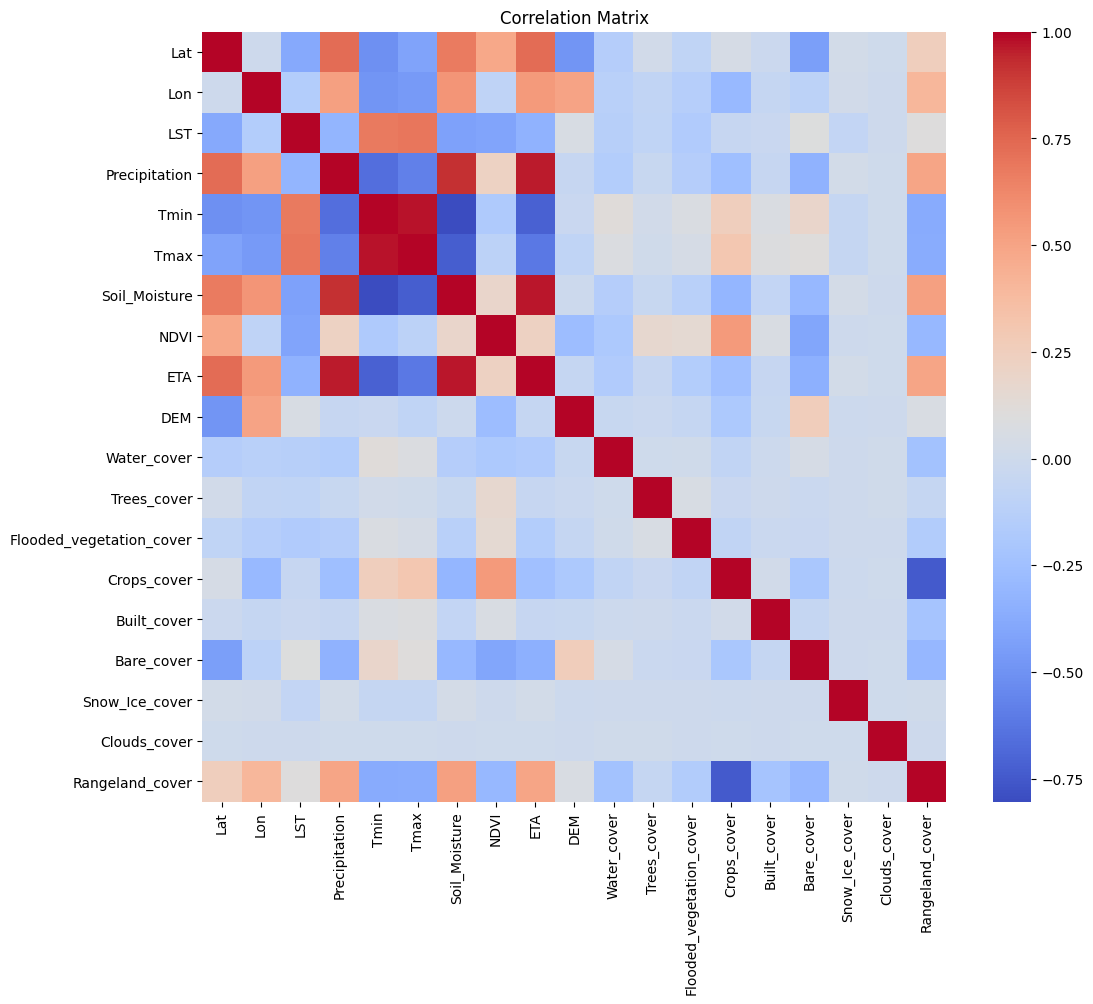

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = data2.corr()

# Optional: Save the correlation matrix to a file
correlation_matrix.to_csv("correlation_matrix.csv")

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")

# Save the figure
plt.savefig("correlation_matrix_heatmap2.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

2025-06-17 13:26:58,168 - INFO - Starting LST prediction pipeline...
2025-06-17 13:26:58,236 - INFO - Data split successfully: 50020 train samples, 12506 test samples
2025-06-17 13:26:58,242 - INFO - Training Linear Regression...
2025-06-17 13:26:58,461 - INFO - Training Random Forest...



Linear Regression:
  Train -> RMSE: 2.4681, MAE: 1.6983, R2: 0.7427, NSE: 0.7427, KGE: 0.8045, PBIAS: -0.0000%
  Test  -> RMSE: 2.4370, MAE: 1.6901, R2: 0.7429, NSE: 0.7429, KGE: 0.8045, PBIAS: -0.0061%
  Runtime: 0.1159 seconds
  Taylor -> Correlation: 0.8619, Std Dev: 4.1657, RMSD: 2.4370


2025-06-17 13:29:12,291 - INFO - Training XGBoost...



Random Forest:
  Train -> RMSE: 0.3420, MAE: 0.2269, R2: 0.9951, NSE: 0.9951, KGE: 0.9863, PBIAS: -0.0026%
  Test  -> RMSE: 0.9051, MAE: 0.6013, R2: 0.9645, NSE: 0.9645, KGE: 0.9863, PBIAS: -0.0290%
  Runtime: 129.7349 seconds
  Taylor -> Correlation: 0.9822, Std Dev: 4.6485, RMSD: 0.9051


2025-06-17 13:29:14,245 - INFO - Plotting error indicators and predictions...



XGBoost:
  Train -> RMSE: 0.8281, MAE: 0.6097, R2: 0.9710, NSE: 0.9710, KGE: 0.9743, PBIAS: 0.0000%
  Test  -> RMSE: 0.9902, MAE: 0.7167, R2: 0.9576, NSE: 0.9576, KGE: 0.9743, PBIAS: -0.0327%
  Runtime: 1.7310 seconds
  Taylor -> Correlation: 0.9786, Std Dev: 4.6675, RMSD: 0.9902


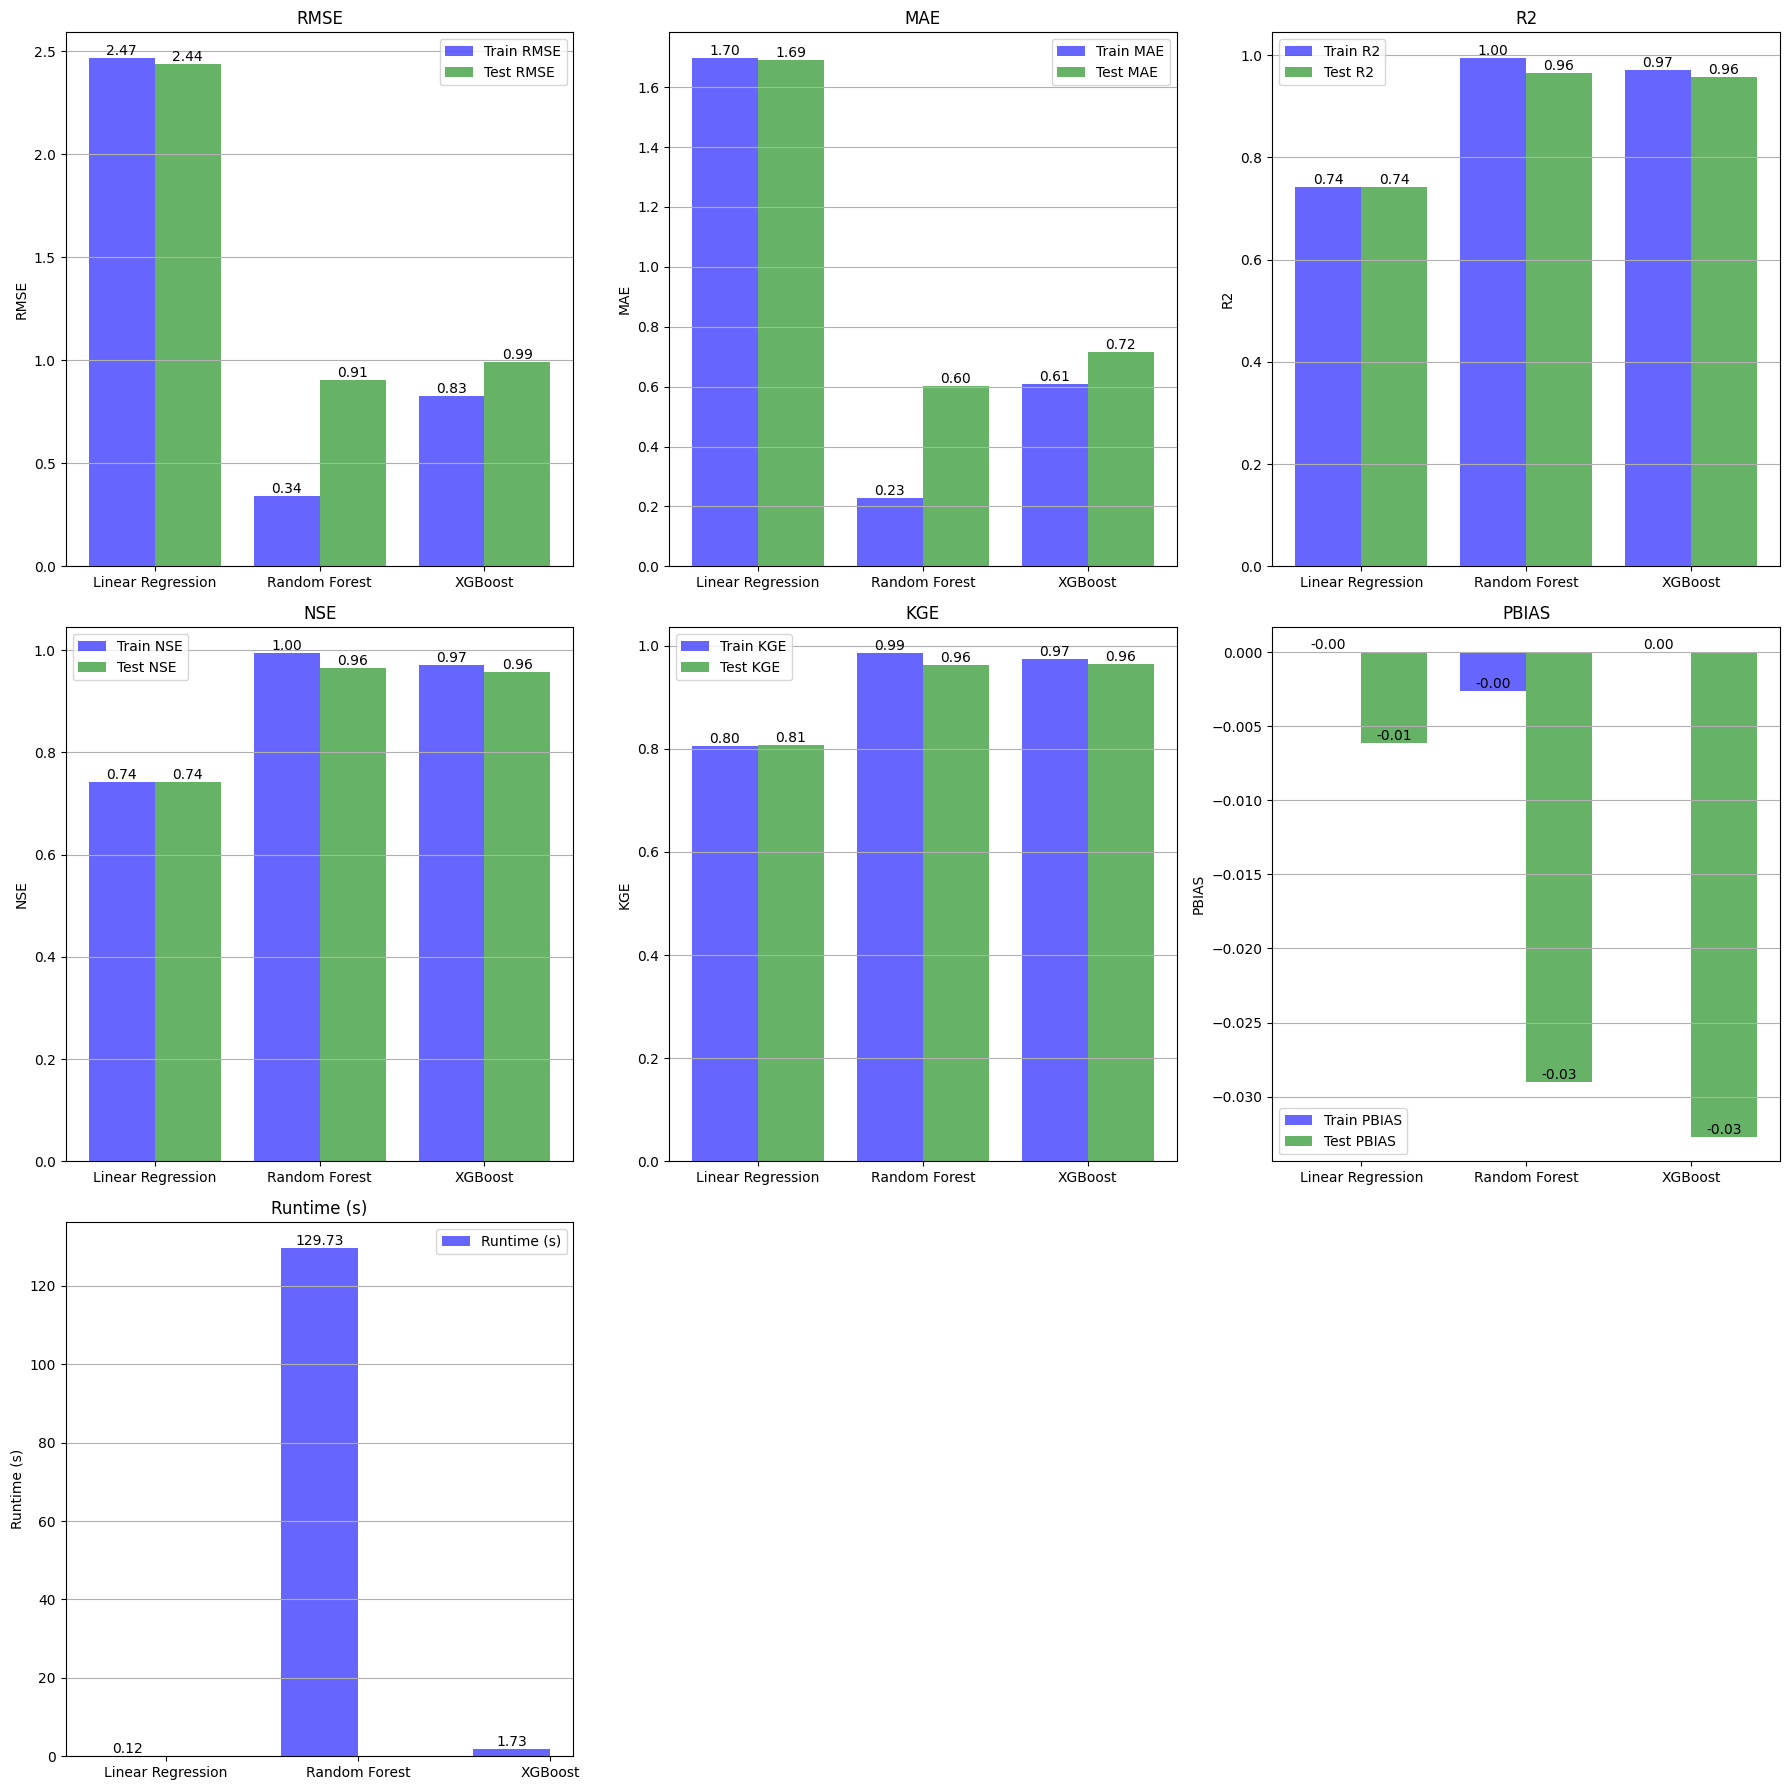

2025-06-17 13:29:24,471 - INFO - Saved model_metrics_comparison.png


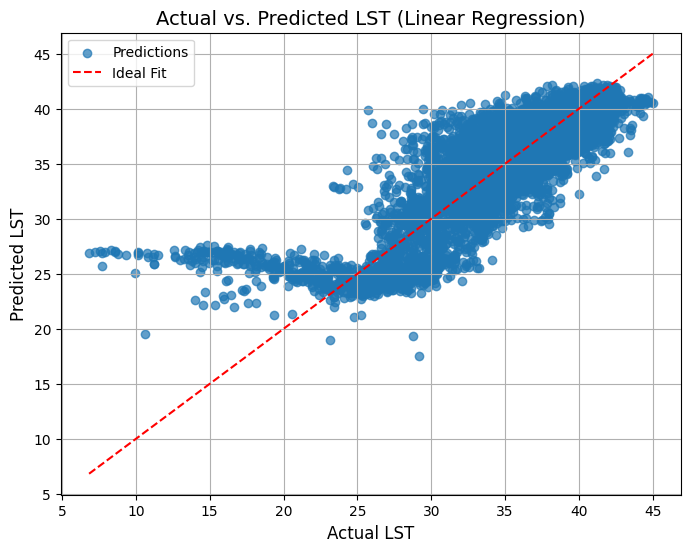

2025-06-17 13:29:27,302 - INFO - Saved figures/actual_vs_predicted_Linear_Regression.png


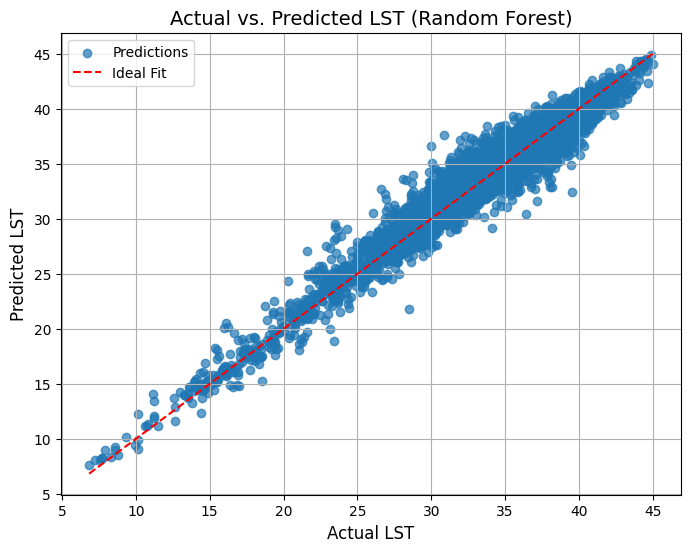

2025-06-17 13:29:30,026 - INFO - Saved figures/actual_vs_predicted_Random_Forest.png


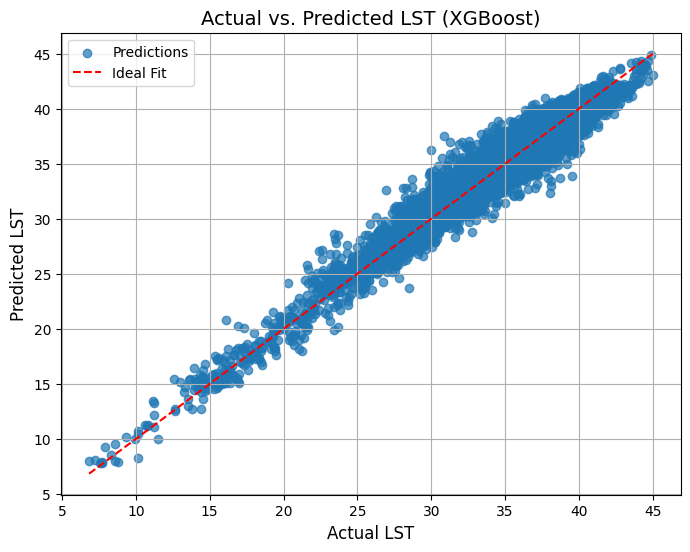

2025-06-17 13:29:32,733 - INFO - Saved figures/actual_vs_predicted_XGBoost.png
2025-06-17 13:29:32,735 - INFO - Plotting feature importance...


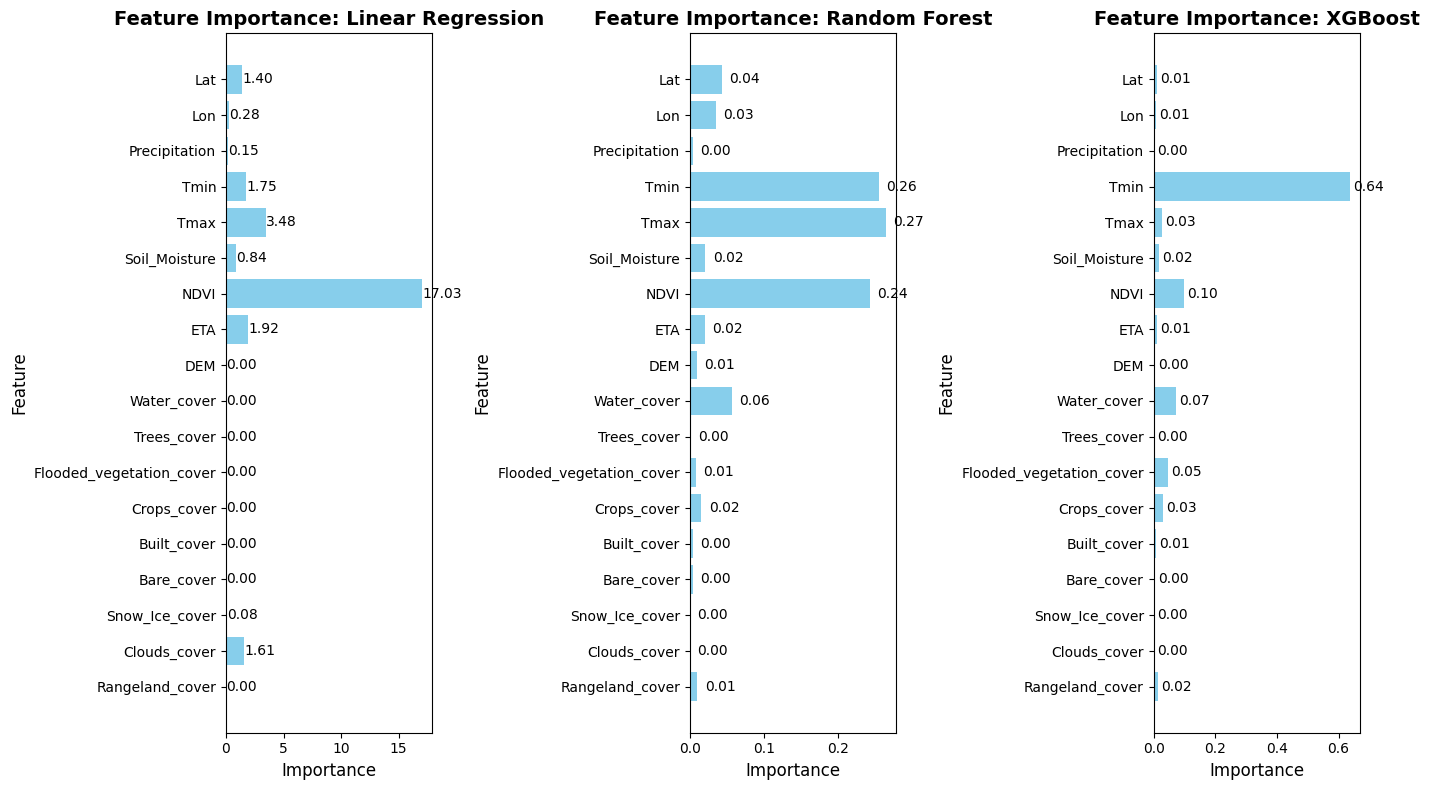

2025-06-17 13:29:38,918 - INFO - Saved feature_importance.png
2025-06-17 13:29:38,920 - INFO - Plotting Taylor Diagram...


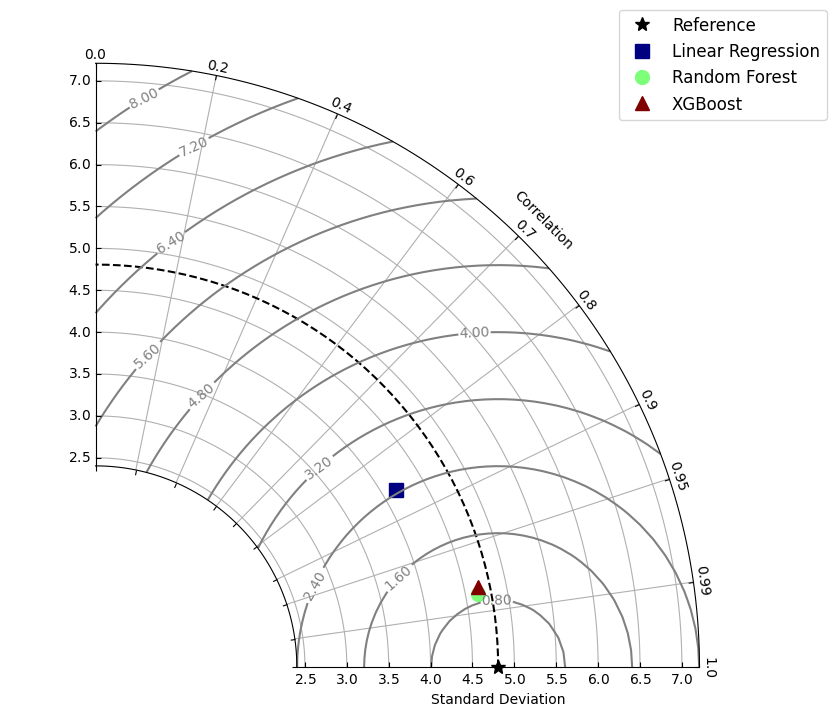

2025-06-17 13:29:40,892 - INFO - Saved taylor_diagram.png
2025-06-17 13:29:40,894 - INFO - Pipeline completed successfully.


In [9]:
"""
Land Surface Temperature (LST) Prediction and Visualization

This script trains machine learning models to predict LST, evaluates their performance,
and generates visualizations including error metrics, actual vs. predicted plots,
feature importance, and a Taylor Diagram.
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as FA
import mpl_toolkits.axisartist.grid_finder as GF
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Utility Functions
def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculate_nse(y_true, y_pred):
    """Calculate Nash-Sutcliffe Efficiency."""
    mean_observed = np.mean(y_true)
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - mean_observed) ** 2)
    return 1 - (numerator / denominator) if denominator != 0 else np.nan

def calculate_kge(y_true, y_pred):
    """Calculate Kling-Gupta Efficiency."""
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = np.std(y_pred) / np.std(y_true) if np.std(y_true) != 0 else np.nan
    beta = np.mean(y_pred) / np.mean(y_true) if np.mean(y_true) != 0 else np.nan
    if np.any(np.isnan([correlation, alpha, beta])):
        return np.nan
    return 1 - np.sqrt((correlation - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

def calculate_pbias(y_true, y_pred):
    """Calculate Percent Bias."""
    return 100 * np.sum(y_true - y_pred) / np.sum(y_true) if np.sum(y_true) != 0 else np.nan

# Taylor Diagram Class
class TaylorDiagram:
    """Taylor diagram for plotting model standard deviation and correlation to reference."""
    def __init__(self, refstd, fig=None, rect=111, label='_', srange=(0, 1.5), extend=False):
        self.refstd = refstd
        tr = PolarAxes.PolarTransform()
        
        rlocs = np.array([0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1])
        if extend:
            self.tmax = np.pi
            rlocs = np.concatenate((-rlocs[:0:-1], rlocs))
        else:
            self.tmax = np.pi/2
        tlocs = np.arccos(rlocs)
        gl1 = GF.FixedLocator(tlocs)
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))
        
        self.smin = srange[0] * self.refstd
        self.smax = srange[1] * self.refstd
        
        ghelper = FA.GridHelperCurveLinear(
            tr,
            extremes=(0, self.tmax, self.smin, self.smax),
            grid_locator1=gl1, tick_formatter1=tf1
        )
        
        if fig is None:
            fig = plt.figure()
        
        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)
        
        ax.axis["top"].set_axis_direction("bottom")
        ax.axis["top"].toggle(ticklabels=True, label=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")
        
        ax.axis["left"].set_axis_direction("bottom")
        ax.axis["left"].label.set_text("Standard Deviation")
        
        ax.axis["right"].set_axis_direction("top")
        ax.axis["right"].toggle(ticklabels=True)
        ax.axis["right"].major_ticklabels.set_axis_direction("left")
        
        if self.smin:
            ax.axis["bottom"].toggle(ticklabels=False, label=False)
        else:
            ax.axis["bottom"].set_visible(False)
            
        self._ax = ax
        self.ax = ax.get_aux_axes(tr)
        
        l, = self.ax.plot([0], self.refstd, 'k*', ls='', ms=10, label=label)
        t = np.linspace(0, self.tmax)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t, r, 'k--', label='_')
        
        self.samplePoints = [l]
    
    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """Add sample to the Taylor diagram."""
        l, = self.ax.plot(np.arccos(corrcoef), stddev, *args, **kwargs)
        self.samplePoints.append(l)
        return l
    
    def add_grid(self, *args, **kwargs):
        """Add grid lines to the diagram."""
        self._ax.grid(*args, **kwargs)
    
    def add_contours(self, levels=10, **kwargs):
        """Add constant centered RMS difference contours."""
        rs, ts = np.meshgrid(np.linspace(self.smin, self.smax), np.linspace(0, self.tmax))
        rms = np.sqrt(self.refstd**2 + rs**2 - 2 * self.refstd * rs * np.cos(ts))
        contours = self.ax.contour(ts, rs, rms, levels, **kwargs)
        return contours

# Part 1: Model Training
def load_and_split_data(data):
    """
    Load and split data into train and test sets.
    
    Args:
        data (pd.DataFrame): Input DataFrame with 'LST' as target and features including 'Lat', 'Lon'.
        
    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    try:
        # Drop 'LST' (target) and keep all other columns as features
        X = data.drop(columns=["LST"])
        y = data["LST"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        logger.info("Data split successfully: %d train samples, %d test samples", len(X_train), len(X_test))
        return X_train, X_test, y_train, y_test
    except KeyError as e:
        logger.error("Column 'LST' not found in data: %s", e)
        raise
    except Exception as e:
        logger.error("Error in data splitting: %s", e)
        raise

def train_models(X_train, y_train, X_test, y_test):
    """
    Train and evaluate machine learning models.
    
    Args:
        X_train, X_test, y_train, y_test: Training and testing data.
        
    Returns:
        dict: Trained models and evaluation results.
    """
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        logger.info("Training %s...", name)
        start_time = time.time()
        try:
            model.fit(X_train, y_train)
            elapsed_time = time.time() - start_time
            
            # Train predictions and metrics
            y_train_pred = model.predict(X_train)
            train_rmse = calculate_rmse(y_train, y_train_pred)
            train_mae = mean_absolute_error(y_train, y_train_pred)
            train_r2 = r2_score(y_train, y_train_pred)
            train_nse = calculate_nse(y_train, y_train_pred)
            train_kge = calculate_kge(y_train, y_train_pred)
            train_pbias = calculate_pbias(y_train, y_train_pred)
            
            # Test predictions and metrics
            y_test_pred = model.predict(X_test)
            test_rmse = calculate_rmse(y_test, y_test_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_r2 = r2_score(y_test, y_test_pred)
            test_nse = calculate_nse(y_test, y_test_pred)
            test_kge = calculate_kge(y_test, y_test_pred)
            test_pbias = calculate_pbias(y_test, y_test_pred)
            
            # Taylor Diagram metrics
            correlation = np.corrcoef(y_test, y_test_pred)[0, 1]
            std_dev = np.std(y_test_pred)
            rmsd = np.sqrt(mean_squared_error(y_test, y_test_pred))
            
            results[name] = {
                "model": model,
                "Train RMSE": train_rmse,
                "Train MAE": train_mae,
                "Train R2": train_r2,
                "Train NSE": train_nse,
                "Train KGE": train_kge,
                "Train PBIAS": train_pbias,
                "Test RMSE": test_rmse,
                "Test MAE": test_mae,
                "Test R2": test_r2,
                "Test NSE": test_nse,
                "Test KGE": test_kge,
                "Test PBIAS": test_pbias,
                "Runtime (s)": elapsed_time,
                "Correlation": correlation,
                "Standard Deviation": std_dev,
                "RMSD": rmsd,
                "y_test_pred": y_test_pred
            }
            
            print(f"\n{name}:")
            print(f"  Train -> RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}, NSE: {train_nse:.4f}, KGE: {train_kge:.4f}, PBIAS: {train_pbias:.4f}%")
            print(f"  Test  -> RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}, NSE: {test_nse:.4f}, KGE: {train_kge:.4f}, PBIAS: {test_pbias:.4f}%")
            print(f"  Runtime: {elapsed_time:.4f} seconds")
            print(f"  Taylor -> Correlation: {correlation:.4f}, Std Dev: {std_dev:.4f}, RMSD: {rmsd:.4f}")
            
        except Exception as e:
            logger.error("Error training %s: %s", name, e)
            continue
    
    return results

# Part 2: Error Indicators and Predictions Visualization
def plot_error_indicators_and_predictions(results, y_test):
    """
    Plot error indicators and actual vs. predicted values.
    
    Args:
        results (dict): Model evaluation results.
        y_test (pd.Series): Actual test target values.
    """
    logger.info("Plotting error indicators and predictions...")
    metrics = ["RMSE", "MAE", "R2", "NSE", "KGE", "PBIAS", "Runtime (s)"]
    num_metrics = len(metrics)
    rows = (num_metrics + 2) // 3
    fig, axes = plt.subplots(rows, 3, figsize=(18, 6 * rows))
    axes = axes.flatten()
    bar_width = 0.4
    x_positions = np.arange(len(results))
    
    for i, metric in enumerate(metrics):
        train_metric = (
            [results[name][f"Train {metric}"] for name in results]
            if metric != "Runtime (s)"
            else [results[name][metric] for name in results]
        )
        test_metric = (
            [results[name][f"Test {metric}"] for name in results]
            if metric != "Runtime (s)"
            else None
        )
        
        bars_train = axes[i].bar(
            x_positions - bar_width / 2, train_metric, bar_width,
            color="blue", alpha=0.6, label=f"Train {metric}" if metric != "Runtime (s)" else metric
        )
        bars_test = None
        if test_metric:
            bars_test = axes[i].bar(
                x_positions + bar_width / 2, test_metric, bar_width,
                color="green", alpha=0.6, label=f"Test {metric}"
            )
        
        for bar in bars_train:
            height = bar.get_height()
            if not np.isnan(height):
                axes[i].text(
                    bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}",
                    ha="center", va="bottom", fontsize=10
                )
        if bars_test:
            for bar in bars_test:
                height = bar.get_height()
                if not np.isnan(height):
                    axes[i].text(
                        bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}",
                        ha="center", va="bottom", fontsize=10
                    )
        
        axes[i].set_title(metric, fontsize=12)
        axes[i].set_xticks(x_positions)
        axes[i].set_xticklabels(results.keys(), fontsize=10)
        axes[i].set_ylabel(metric, fontsize=10)
        axes[i].tick_params(axis="both", labelsize=10)
        axes[i].legend(fontsize=10)
        axes[i].grid(axis="y")
    
    for j in range(len(metrics), len(axes)):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.savefig("figures/model_metrics_comparison.png", dpi=300, bbox_inches="tight")
    plt.show()
    logger.info("Saved model_metrics_comparison.png")
    
    for name, result in results.items():
        y_pred = result["y_test_pred"]
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, label="Predictions")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="Ideal Fit")
        plt.xlabel("Actual LST", fontsize=12)
        plt.ylabel("Predicted LST", fontsize=12)
        plt.title(f"Actual vs. Predicted LST ({name})", fontsize=14)
        plt.legend(fontsize=10)
        plt.grid()
        filename = f"figures/actual_vs_predicted_{name.replace(' ', '_')}.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.show()
        logger.info("Saved %s", filename)

# Part 3: Feature Importance Visualization
def plot_feature_importance(results, X_train):
    """
    Plot feature importance for each model.
    
    Args:
        results (dict): Model evaluation results.
        X_train (pd.DataFrame): Training features.
    """
    logger.info("Plotting feature importance...")
    feature_importance_df = pd.DataFrame()
    
    for name, result in results.items():
        model = result["model"]
        if name == "Linear Regression":
            importance = np.abs(model.coef_)
        else:
            importance = model.feature_importances_
        
        temp_df = pd.DataFrame({
            "Model": name,
            "Feature": X_train.columns,
            "Importance": importance
        })
        feature_importance_df = pd.concat([feature_importance_df, temp_df], ignore_index=True)
    
    plt.figure(figsize=(14, 8))
    for i, model_name in enumerate(results.keys()):
        plt.subplot(1, len(results), i + 1)
        model_df = feature_importance_df[feature_importance_df["Model"] == model_name]
        bars = plt.barh(model_df["Feature"], model_df["Importance"], color="skyblue")
        plt.title(f"Feature Importance: {model_name}", fontsize=14, weight='bold')
        plt.xlabel("Importance", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.gca().invert_yaxis()
        plt.yticks(fontsize=10)
        plt.xticks(fontsize=10)
        
        for bar in bars:
            width = bar.get_width()
            plt.text(
                width + 0.01, bar.get_y() + bar.get_height() / 2,
                f"{width:.2f}", ha="left", va="center", fontsize=10
            )
    
    plt.tight_layout()
    plt.savefig("figures/feature_importance.png", dpi=300, bbox_inches="tight")
    plt.show()
    logger.info("Saved feature_importance.png")

# Part 4: Taylor Diagram Visualization
def plot_taylor_diagram(results, y_test):
    """
    Plot Taylor Diagram for model comparison.
    
    Args:
        results (dict): Model evaluation results.
        y_test (pd.Series): Actual test target values.
    """
    logger.info("Plotting Taylor Diagram...")
    refstd = y_test.std()
    fig = plt.figure(figsize=(10, 8))
    dia = TaylorDiagram(refstd, fig=fig, rect=111, label="Reference", srange=(0.5, 1.5))
    
    model_markers = ['s', 'o', '^']
    colors = plt.cm.jet(np.linspace(0, 1, len(results)))
    
    for i, (model_name, result) in enumerate(results.items()):
        stddev = result["Standard Deviation"]
        corrcoef = result["Correlation"]
        if not np.isnan(stddev) and not np.isnan(corrcoef):
            dia.add_sample(
                stddev, corrcoef,
                marker=model_markers[i], ms=10, ls='',
                mfc=colors[i], mec=colors[i],
                label=model_name
            )
    
    dia.add_grid()
    contours = dia.add_contours(colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
    
    fig.legend(
        dia.samplePoints,
        [p.get_label() for p in dia.samplePoints],
        numpoints=1, prop=dict(size='large'),
        loc='upper right', bbox_to_anchor=(0.95, 0.95)
    )
    
    dia._ax.tick_params(axis='y', labelsize=10)
    plt.savefig("figures/taylor_diagram.png", dpi=300, bbox_inches="tight")
    plt.show()
    logger.info("Saved taylor_diagram.png")

def main():
    """
    Main function to run the analysis pipeline.
    """
    logger.info("Starting LST prediction pipeline...")
    try:
        # Use the preprocessed data2 DataFrame
        global data2  # Assume data2 is available in the global scope from previous code
        if data2.empty:
            logger.error("No data provided. Please ensure data2 is properly defined.")
            raise ValueError("DataFrame data2 is empty")
        
        # Part 1: Data Splitting and Model Training
        X_train, X_test, y_train, y_test = load_and_split_data(data2)
        results = train_models(X_train, y_train, X_test, y_test)
        if not results:
            logger.error("No models were successfully trained.")
            raise ValueError("Model training failed")
        
        # Part 2: Error Indicators and Predictions Visualization
        plot_error_indicators_and_predictions(results, y_test)
        
        # Part 3: Feature Importance Visualization
        plot_feature_importance(results, X_train)
        
        # Part 4: Taylor Diagram Visualization
        plot_taylor_diagram(results, y_test)
        
        logger.info("Pipeline completed successfully.")
        
    except Exception as e:
        logger.error("Pipeline failed: %s", e)
        raise

if __name__ == "__main__":
    main()

2025-06-17 17:25:51,481 - INFO - Starting SHAP analysis pipeline...
2025-06-17 17:25:51,533 - INFO - Data split successfully: 50020 train samples, 12506 test samples
2025-06-17 17:25:51,537 - INFO - Training XGBoost model...
2025-06-17 17:25:55,282 - INFO - XGBoost training completed. Progress: 16.67%
2025-06-17 17:25:55,581 - INFO - Predictions completed. Progress: 33.33%
2025-06-17 17:25:55,599 - INFO - Metrics calculation completed. Progress: 50.00%
2025-06-17 17:25:55,601 - INFO - Plotting actual vs. predicted values...


XGBoost Metrics:
Train - MSE: 0.6858, RMSE: 0.8281, R2: 0.9710
Test  - MSE: 0.9804, RMSE: 0.9902, R2: 0.9576


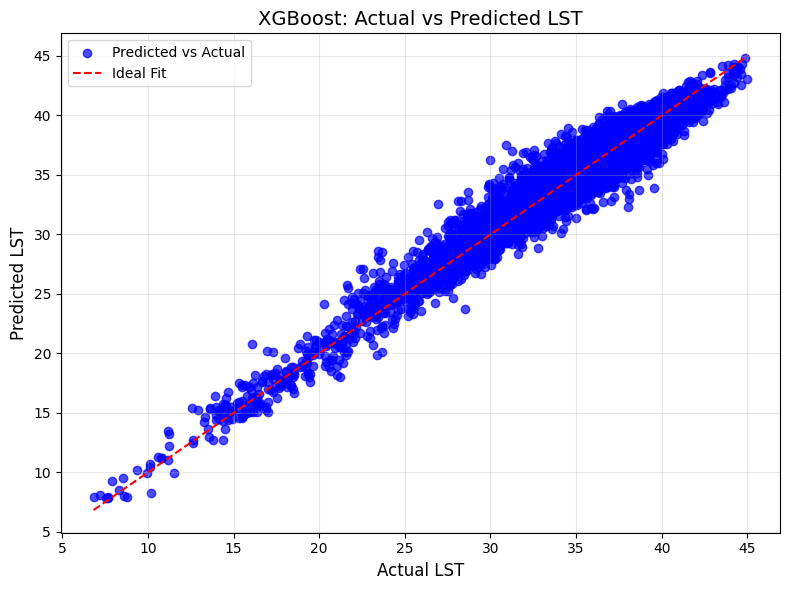

2025-06-17 17:25:58,784 - INFO - Actual vs predicted plot completed. Progress: 66.67%
2025-06-17 17:25:58,786 - INFO - Saved figures/xgboost_actual_vs_predicted.png
2025-06-17 17:25:58,787 - INFO - Generating SHAP explanations...
[17:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
2025-06-17 17:26:23,774 - INFO - Creating SHAP summary plot...


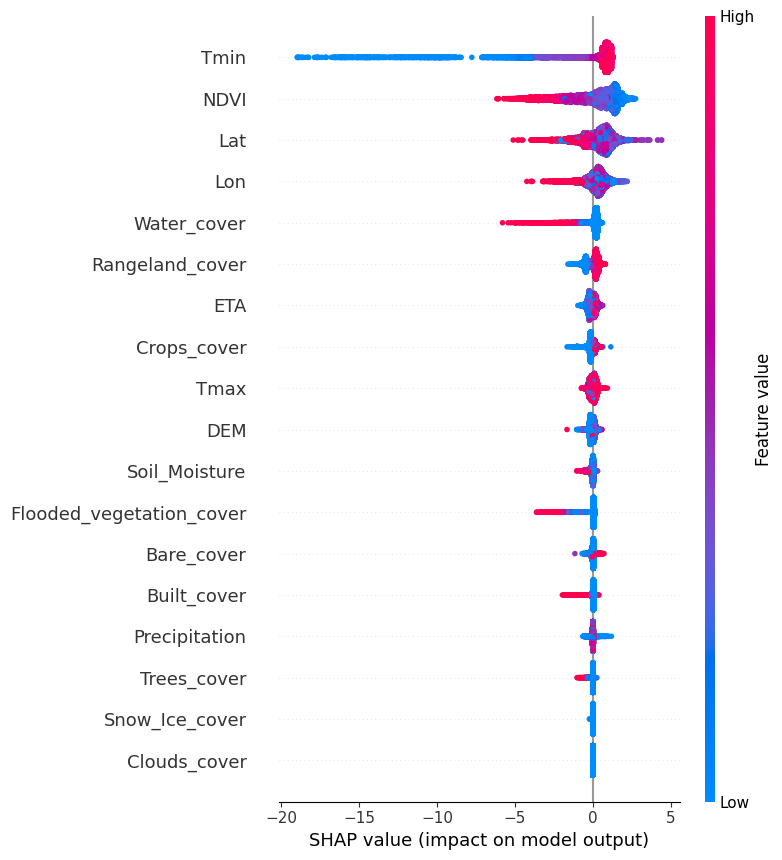

2025-06-17 17:26:39,242 - INFO - Saved figures/shap_summary.png
2025-06-17 17:26:39,243 - INFO - Creating SHAP dependence plot for Lat...


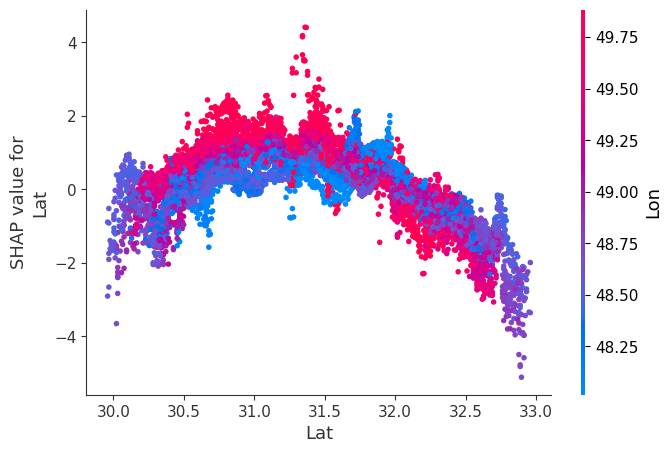

2025-06-17 17:26:42,231 - INFO - Saved figures/shap_dependence_Lat.png
2025-06-17 17:26:42,232 - INFO - Creating SHAP dependence plot for Lon...


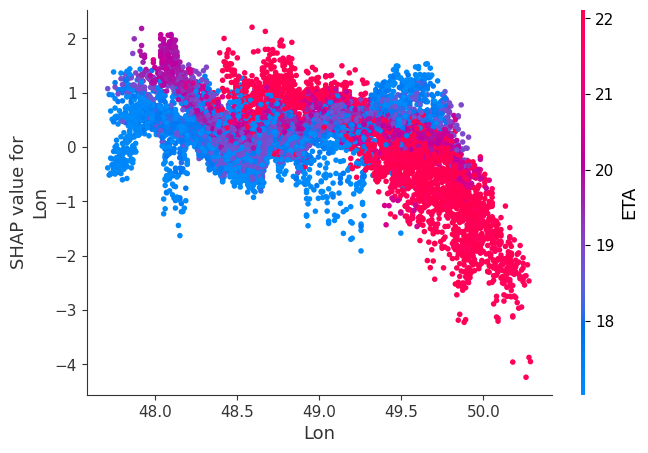

2025-06-17 17:26:44,991 - INFO - Saved figures/shap_dependence_Lon.png
2025-06-17 17:26:44,992 - INFO - Creating SHAP dependence plot for Precipitation...


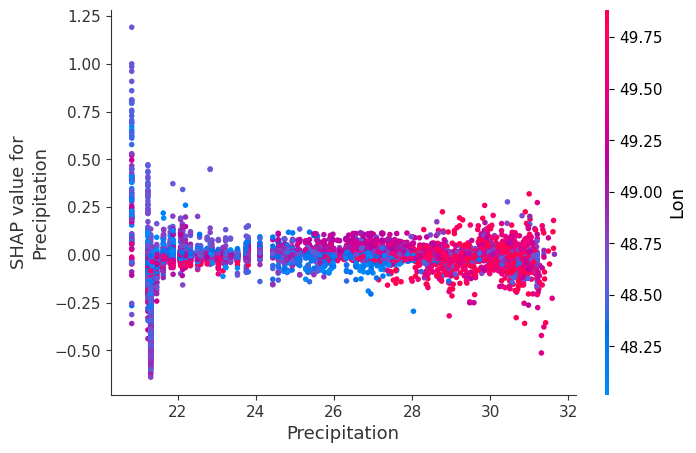

2025-06-17 17:26:47,622 - INFO - Saved figures/shap_dependence_Precipitation.png
2025-06-17 17:26:47,624 - INFO - Creating SHAP dependence plot for Tmin...


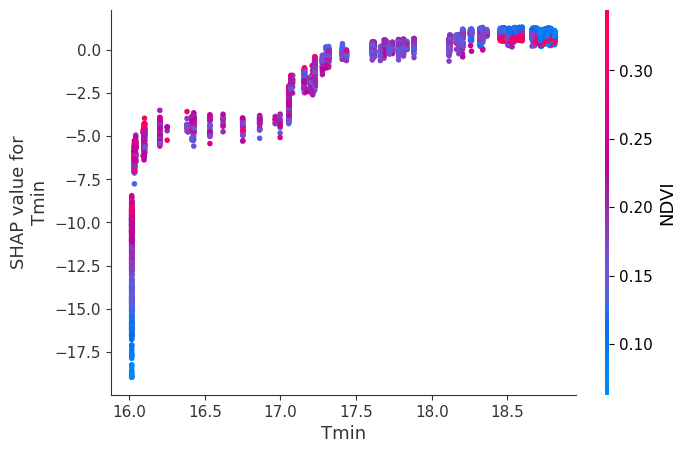

2025-06-17 17:26:50,256 - INFO - Saved figures/shap_dependence_Tmin.png
2025-06-17 17:26:50,258 - INFO - Creating SHAP dependence plot for Tmax...


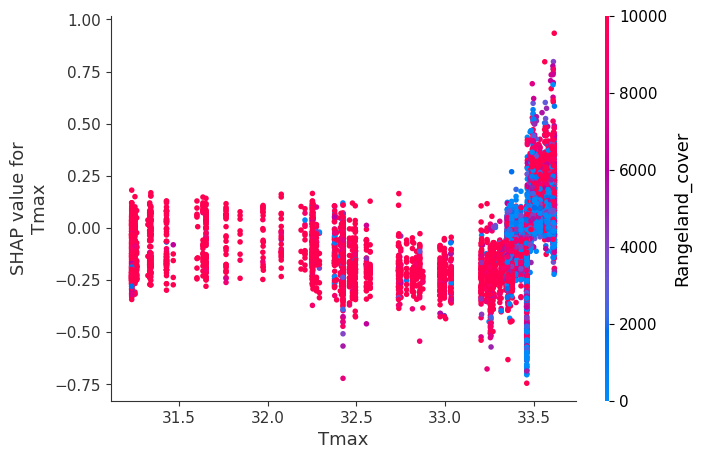

2025-06-17 17:26:53,406 - INFO - Saved figures/shap_dependence_Tmax.png
2025-06-17 17:26:53,408 - INFO - Creating SHAP dependence plot for Soil_Moisture...


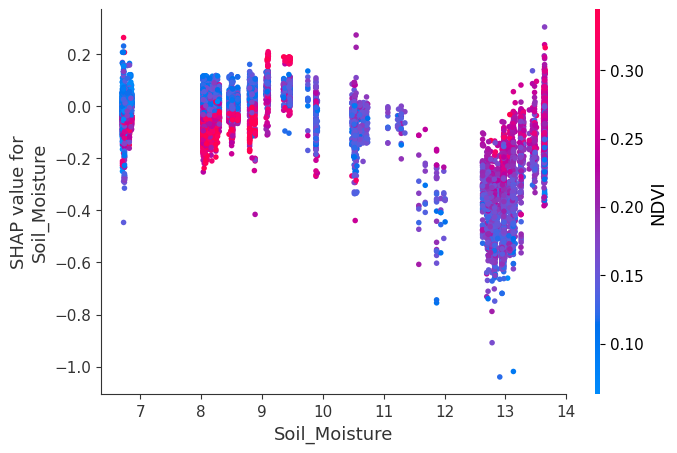

2025-06-17 17:26:56,461 - INFO - Saved figures/shap_dependence_Soil_Moisture.png
2025-06-17 17:26:56,462 - INFO - Creating SHAP dependence plot for NDVI...


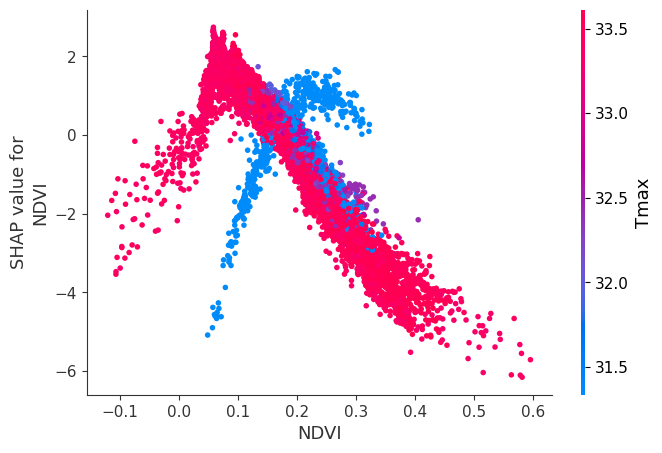

2025-06-17 17:26:59,466 - INFO - Saved figures/shap_dependence_NDVI.png
2025-06-17 17:26:59,467 - INFO - Creating SHAP dependence plot for ETA...


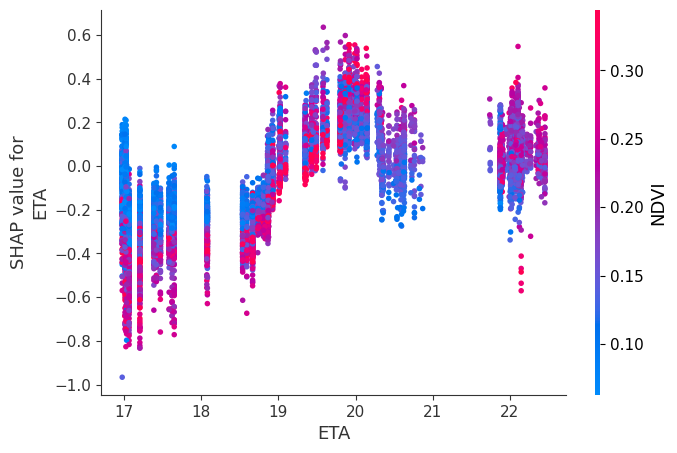

2025-06-17 17:27:02,851 - INFO - Saved figures/shap_dependence_ETA.png
2025-06-17 17:27:02,855 - INFO - Creating SHAP dependence plot for DEM...


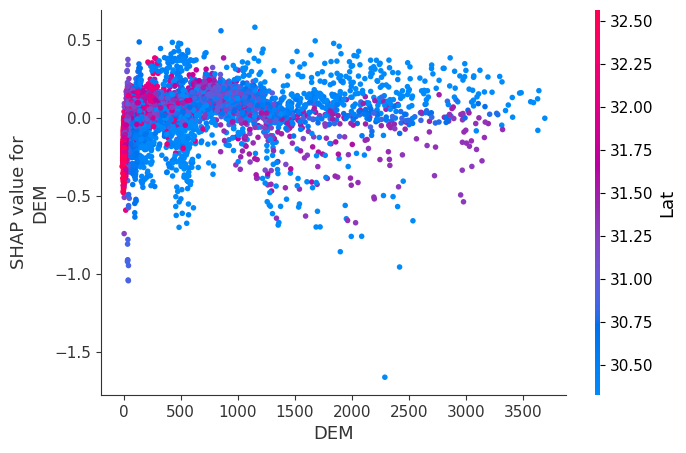

2025-06-17 17:27:06,943 - INFO - Saved figures/shap_dependence_DEM.png
2025-06-17 17:27:06,945 - INFO - Creating SHAP dependence plot for Water_cover...


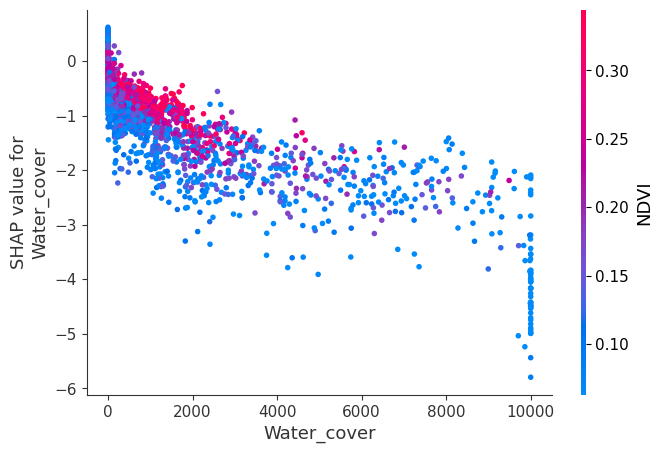

2025-06-17 17:27:11,207 - INFO - Saved figures/shap_dependence_Water_cover.png
2025-06-17 17:27:11,208 - INFO - Creating SHAP dependence plot for Trees_cover...


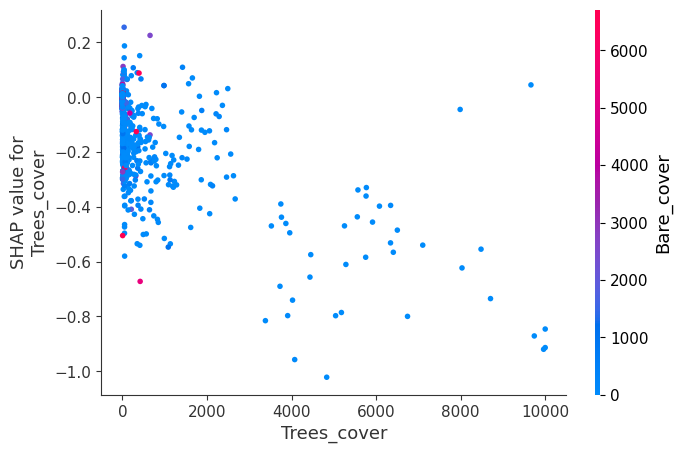

2025-06-17 17:27:15,810 - INFO - Saved figures/shap_dependence_Trees_cover.png
2025-06-17 17:27:15,812 - INFO - Creating SHAP dependence plot for Flooded_vegetation_cover...


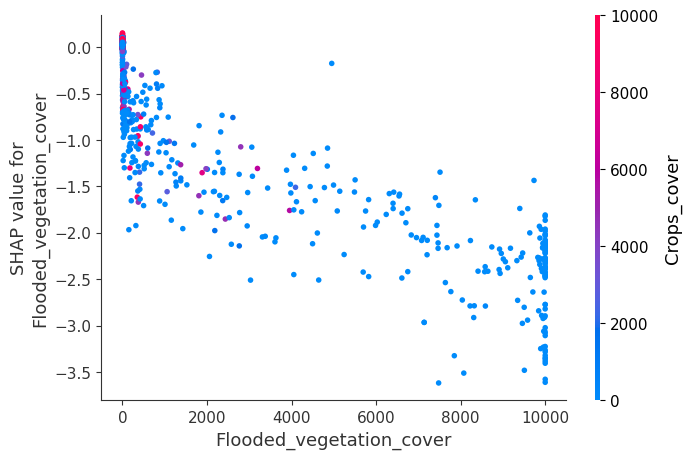

2025-06-17 17:27:20,190 - INFO - Saved figures/shap_dependence_Flooded_vegetation_cover.png
2025-06-17 17:27:20,191 - INFO - Creating SHAP dependence plot for Crops_cover...


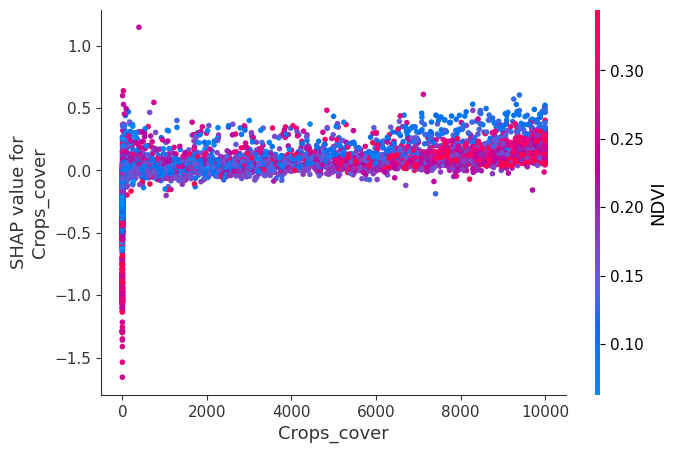

2025-06-17 17:27:24,445 - INFO - Saved figures/shap_dependence_Crops_cover.png
2025-06-17 17:27:24,447 - INFO - Creating SHAP dependence plot for Built_cover...


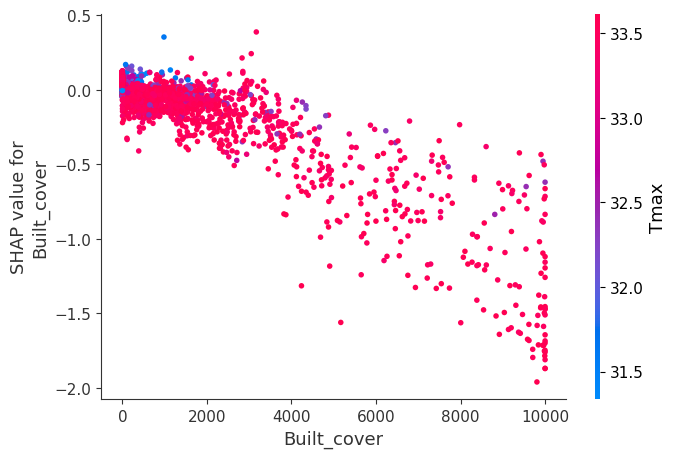

2025-06-17 17:27:28,012 - INFO - Saved figures/shap_dependence_Built_cover.png
2025-06-17 17:27:28,013 - INFO - Creating SHAP dependence plot for Bare_cover...


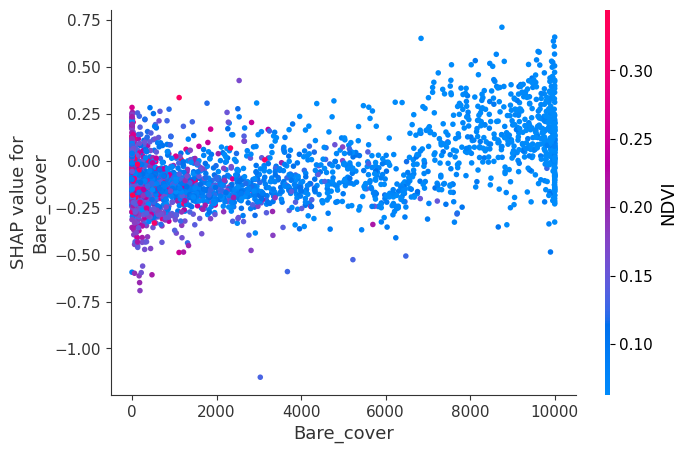

2025-06-17 17:27:31,333 - INFO - Saved figures/shap_dependence_Bare_cover.png
2025-06-17 17:27:31,335 - INFO - Creating SHAP dependence plot for Snow_Ice_cover...


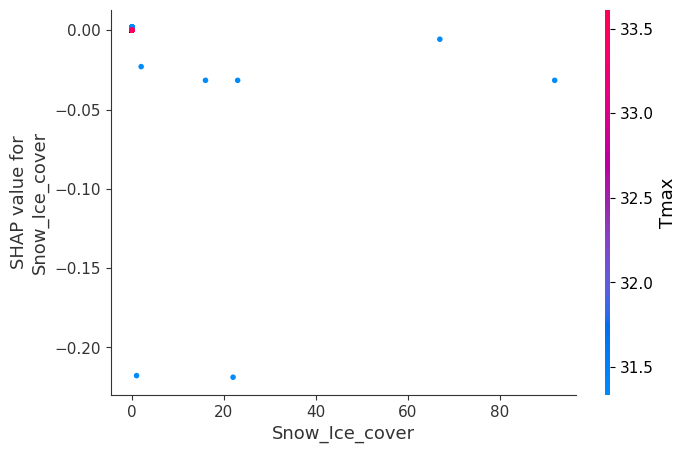

2025-06-17 17:27:35,030 - INFO - Saved figures/shap_dependence_Snow_Ice_cover.png
2025-06-17 17:27:35,031 - INFO - Creating SHAP dependence plot for Clouds_cover...


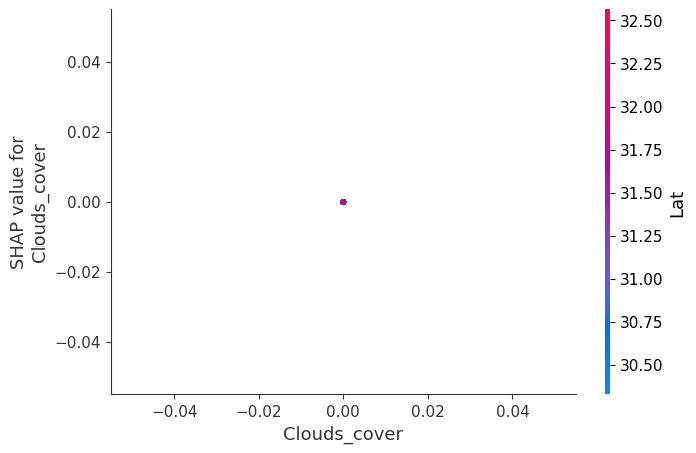

2025-06-17 17:27:38,880 - INFO - Saved figures/shap_dependence_Clouds_cover.png
2025-06-17 17:27:38,881 - INFO - Creating SHAP dependence plot for Rangeland_cover...


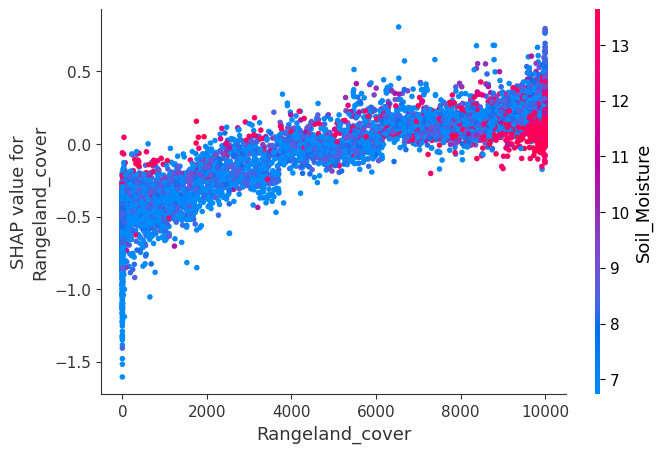

2025-06-17 17:27:42,952 - INFO - Saved figures/shap_dependence_Rangeland_cover.png
2025-06-17 17:27:42,953 - INFO - SHAP explanations completed. Progress: 83.33%
2025-06-17 17:27:42,954 - INFO - Plotting feature importance...


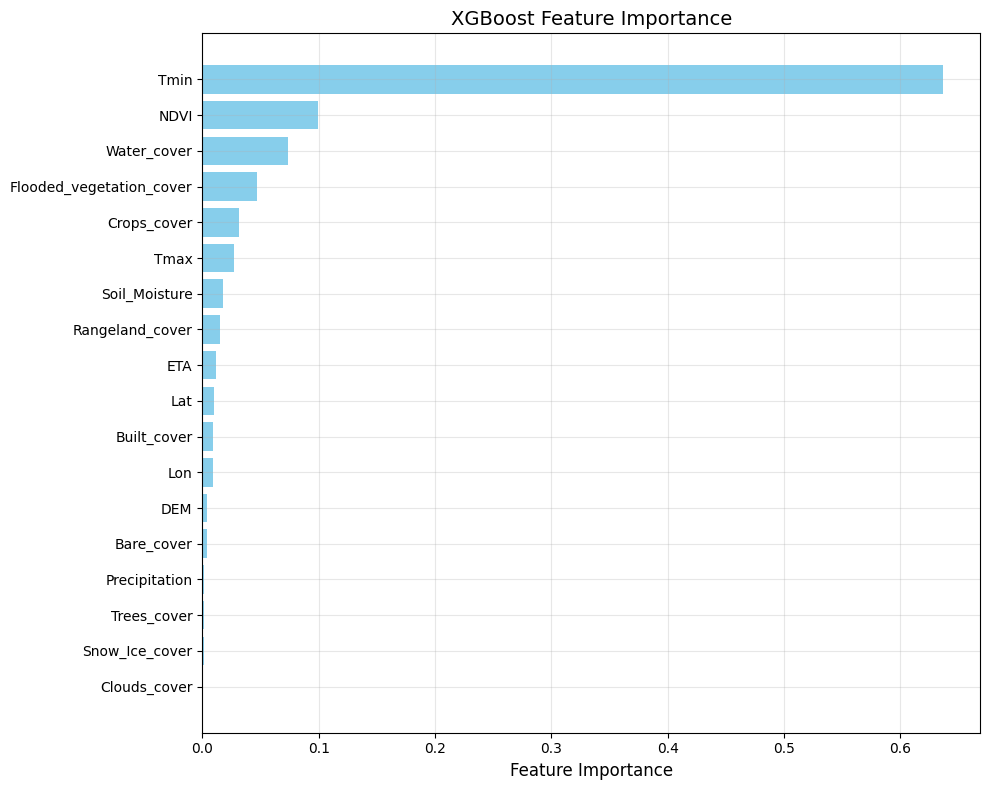

2025-06-17 17:27:45,677 - INFO - Feature importance plot completed. Progress: 100.00%
2025-06-17 17:27:45,678 - INFO - Saved figures/xgboost_feature_importance.png
2025-06-17 17:27:45,680 - INFO - Generating model schematic...
2025-06-17 17:27:45,686 - INFO - Model schematic completed. Progress: 116.67%
2025-06-17 17:27:45,689 - INFO - SHAP analysis pipeline completed successfully.



Model Schematic:
--------------------------------------------------
1. Input Data:
   - Features: ['Lat', 'Lon', 'Precipitation', 'Tmin', 'Tmax', 'Soil_Moisture', 'NDVI', 'ETA', 'DEM', 'Water_cover', 'Trees_cover', 'Flooded_vegetation_cover', 'Crops_cover', 'Built_cover', 'Bare_cover', 'Snow_Ice_cover', 'Clouds_cover', 'Rangeland_cover']
   - Target: LST
2. Model Architecture:
   - XGBoost Regressor (100 estimators, random_state=42)
3. Training & Validation:
   - 80/20 Train-Test Split
   - Metrics: MSE, RMSE, R2
4. SHAP Analysis:
   - Global Summary Plot
   - Local Dependence Plots
   - Feature Importance
5. Outputs:
   - Predictions
   - Visualizations (saved to figures/)
--------------------------------------------------


In [20]:
"""
SHAP Analysis for XGBoost Land Surface Temperature (LST) Prediction

This script trains an XGBoost model to predict LST, evaluates its performance with MSE, RMSE, and R2 metrics,
generates SHAP explanations for feature importance, and visualizes actual vs. predicted values, SHAP summary,
dependence plots, and feature importance.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import shap
import logging
import os

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

# Progress tracker
total_steps = 6
completed_steps = 0

def update_progress(step_name):
    """Update and log progress percentage."""
    global completed_steps
    completed_steps += 1
    progress_percent = (completed_steps / total_steps) * 100
    logger.info(f"{step_name} completed. Progress: {progress_percent:.2f}%")

def load_and_split_data(data):
    """
    Split data into training and test sets for XGBoost model.

    Args:
        data (pd.DataFrame): Input DataFrame with 'LST' as target and features.

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    try:
        X = data2.drop(columns=["LST"])  # Features (keep Lat, Lon, etc.)
        y = data2["LST"]  # Target
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        logger.info("Data split successfully: %d train samples, %d test samples", len(X_train), len(X_test))
        return X_train, X_test, y_train, y_test
    except KeyError as e:
        logger.error("Column 'LST' not found in data: %s", e)
        raise
    except Exception as e:
        logger.error("Error in data splitting: %s", e)
        raise

def train_and_evaluate_xgboost(X_train, y_train, X_test, y_test):
    """
    Train XGBoost model and evaluate performance.

    Args:
        X_train, X_test, y_train, y_test: Training and test data.

    Returns:
        dict: Model, predictions, and metrics.
    """
    logger.info("Training XGBoost model...")
    try:
        # Initialize and train model
        model = XGBRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        update_progress("XGBoost training")

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        update_progress("Predictions")

        # Metrics
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)

        results = {
            "model": model,
            "y_pred_train": y_pred_train,
            "y_pred_test": y_pred_test,
            "mse_train": mse_train,
            "mse_test": mse_test,
            "rmse_train": rmse_train,
            "rmse_test": rmse_test,
            "r2_train": r2_train,
            "r2_test": r2_test
        }

        # Print metrics
        print(f"XGBoost Metrics:")
        print(f"Train - MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
        print(f"Test  - MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")
        update_progress("Metrics calculation")

        return results

    except Exception as e:
        logger.error("Error in XGBoost training or evaluation: %s", e)
        raise

def plot_actual_vs_predicted(y_test, y_pred_test):
    """
    Plot actual vs. predicted values for XGBoost model.

    Args:
        y_test (pd.Series): Actual test target values.
        y_pred_test (np.ndarray): Predicted test values.
    """
    logger.info("Plotting actual vs. predicted values...")
    try:
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred_test, alpha=0.7, label="Predicted vs Actual", color="blue")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="Ideal Fit")
        plt.xlabel("Actual LST", fontsize=12)
        plt.ylabel("Predicted LST", fontsize=12)
        plt.title("XGBoost: Actual vs Predicted LST", fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("figures/xgboost_actual_vs_predicted.png", dpi=300, bbox_inches="tight")
        plt.show()
        update_progress("Actual vs predicted plot")
        logger.info("Saved figures/xgboost_actual_vs_predicted.png")

    except Exception as e:
        logger.error("Error in plotting actual vs predicted: %s", e)
        raise

def generate_shap_explanations(model, X_test, X):
    """
    Generate SHAP explanations and plots.

    Args:
        model: Trained XGBoost model.
        X_test (pd.DataFrame): Test features.
        X (pd.DataFrame): Full feature set for column names.
    """
    logger.info("Generating SHAP explanations...")
    try:
        # SHAP explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_test)

        # SHAP summary plot
        logger.info("Creating SHAP summary plot...")
        shap.summary_plot(shap_values.values, X_test, feature_names=X.columns, show=False)
        plt.savefig("figures/shap_summary.png", dpi=300, bbox_inches="tight")
        plt.show()
        logger.info("Saved figures/shap_summary.png")

        # SHAP dependence plots
        for feature in X.columns:
            logger.info(f"Creating SHAP dependence plot for {feature}...")
            shap.dependence_plot(
                feature, shap_values.values, X_test, feature_names=X.columns, show=False
            )
            plt.savefig(f"figures/shap_dependence_{feature}.png", dpi=300, bbox_inches="tight")
            plt.show()
            logger.info(f"Saved figures/shap_dependence_{feature}.png")

        update_progress("SHAP explanations")

    except Exception as e:
        logger.error("Error in SHAP explanations: %s", e)
        raise

def plot_feature_importance(model, X):
    """
    Plot XGBoost feature importance.

    Args:
        model: Trained XGBoost model.
        X (pd.DataFrame): Features for column names.
    """
    logger.info("Plotting feature importance...")
    try:
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color="skyblue")
        plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx], fontsize=10)
        plt.xlabel("Feature Importance", fontsize=12)
        plt.title("XGBoost Feature Importance", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig("figures/xgboost_feature_importance.png", dpi=300, bbox_inches="tight")
        plt.show()
        update_progress("Feature importance plot")
        logger.info("Saved figures/xgboost_feature_importance.png")

    except Exception as e:
        logger.error("Error in plotting feature importance: %s", e)
        raise

def generate_model_schematic(X):
    """
    Print a schematic of the model pipeline.

    Args:
        X (pd.DataFrame): Features for column names.
    """
    logger.info("Generating model schematic...")
    try:
        print("\nModel Schematic:")
        print("-" * 50)
        print("1. Input Data:")
        print(f"   - Features: {list(X.columns)}")
        print("   - Target: LST")
        print("2. Model Architecture:")
        print("   - XGBoost Regressor (100 estimators, random_state=42)")
        print("3. Training & Validation:")
        print("   - 80/20 Train-Test Split")
        print("   - Metrics: MSE, RMSE, R2")
        print("4. SHAP Analysis:")
        print("   - Global Summary Plot")
        print("   - Local Dependence Plots")
        print("   - Feature Importance")
        print("5. Outputs:")
        print("   - Predictions")
        print("   - Visualizations (saved to figures/)")
        print("-" * 50)
        update_progress("Model schematic")

    except Exception as e:
        logger.error("Error in generating model schematic: %s", e)
        raise

def main():
    """
    Main function to run the SHAP analysis pipeline.
    """
    global completed_steps
    completed_steps = 0  # Reset progress
    logger.info("Starting SHAP analysis pipeline...")
    try:
        # Use the preprocessed data2 DataFrame
        global data2  # Assume data2 is available from preprocessing code
        if data2.empty:
            logger.error("No data provided. Please ensure data2 is properly defined.")
            raise ValueError("DataFrame data2 is empty")

        # Load and split data
        X_train, X_test, y_train, y_test = load_and_split_data(data2)

        # Train and evaluate XGBoost
        results = train_and_evaluate_xgboost(X_train, y_train, X_test, y_test)

        # Plot actual vs predicted
        plot_actual_vs_predicted(y_test, results["y_pred_test"])

        # Generate SHAP explanations
        generate_shap_explanations(results["model"], X_test, X_train)

        # Plot feature importance
        plot_feature_importance(results["model"], X_train)

        # Generate model schematic
        generate_model_schematic(X_train)

        logger.info("SHAP analysis pipeline completed successfully.")

    except Exception as e:
        logger.error("SHAP pipeline failed: %s", e)
        raise

if __name__ == "__main__":
    main()

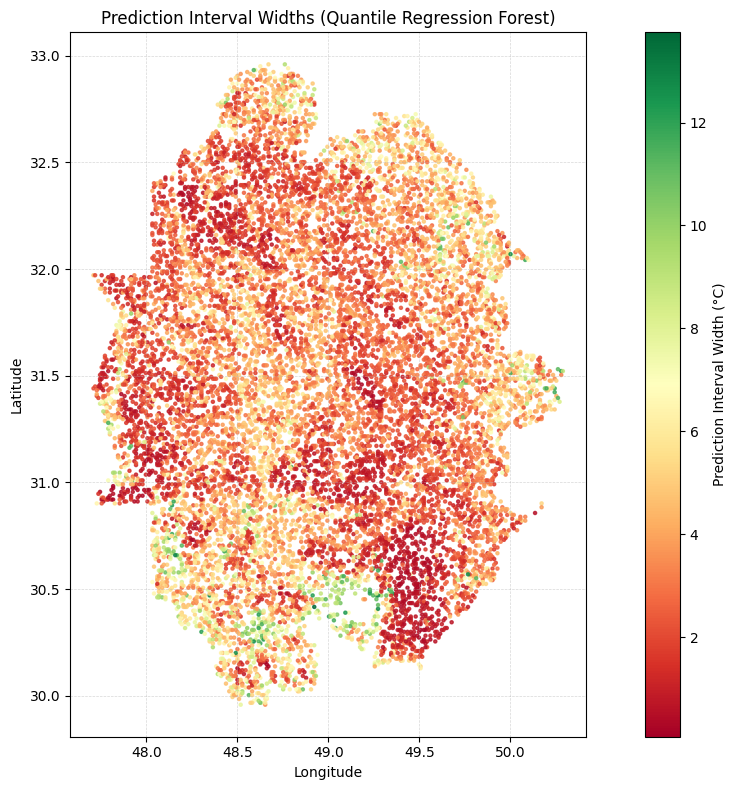

In [13]:
import matplotlib.pyplot as plt
import geopandas as gpd
from quantile_forest import RandomForestQuantileRegressor
from sklearn.model_selection import train_test_split

# Ensure no missing values
data2 = data2.dropna()

# Separate predictors (X) and target (y)
X = data2.drop(columns=["LST"])  # Retain Lat and Lon in X
y = data2["LST"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save Lat and Lon from X_test for mapping
lat_lon_test = X_test[["Lat", "Lon"]].reset_index(drop=True)

# Initialize and train the Quantile Regression Forest model
qrf = RandomForestQuantileRegressor(random_state=42)
qrf.fit(X_train, y_train)

# Predict quantiles on test data
quantiles = [0.025, 0.5, 0.975]  # 2.5th, 50th, and 97.5th percentiles
y_test_quantiles = qrf.predict(X_test, quantiles=quantiles)

# Extract individual quantiles
y_test_lower = y_test_quantiles[:, 0]  # 2.5th percentile
y_test_median = y_test_quantiles[:, 1]  # 50th percentile
y_test_upper = y_test_quantiles[:, 2]  # 97.5th percentile

# Calculate the interval width
interval_widths = y_test_upper - y_test_lower

# Create a GeoDataFrame for mapping
gdf = gpd.GeoDataFrame(
    {
        "Lat": lat_lon_test["Lat"],
        "Lon": lat_lon_test["Lon"],
        "Interval_Width": interval_widths,
        "y_test": y_test.reset_index(drop=True),
        "y_test_median": y_test_median,
        "y_test_lower": y_test_lower,
        "y_test_upper": y_test_upper,
    },
    geometry=gpd.points_from_xy(lat_lon_test["Lon"], lat_lon_test["Lat"]),
    crs="EPSG:4326"  # WGS84 coordinate reference system
)

# Plot the map of interval widths
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(
    column="Interval_Width",
    cmap="RdYlGn",
    legend=True,
    legend_kwds={"label": "Prediction Interval Width (°C)"},
    ax=ax,
    markersize=5,
    alpha=0.8
)

# Add map details
plt.title("Prediction Interval Widths (Quantile Regression Forest)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()

# Save the plot if needed
plt.savefig("prediction_interval_widths_map_red_to_green.png", dpi=300)
plt.show()



In [1]:
"""
Quantile Regression Forest (QRF) for Land Surface Temperature (LST) Prediction

This script trains a Quantile Regression Forest model to predict LST with uncertainty
quantiles (2.5th, 50th, 97.5th percentiles), evaluates the percentage of data within
prediction intervals, and visualizes results with a scatter plot for 200 sample points.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from quantile_forest import RandomForestQuantileRegressor
import logging
import os

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Create figures directory if it doesn't exist
os.makedirs('figures', exist_ok=True)

def load_and_split_data(data):
    """
    Split data into training and test sets for QRF model.

    Args:
        data (pd.DataFrame): Input DataFrame with 'LST' as target and features.

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    try:
        X = data.drop(columns=["LST"])  # Features (keep Lat, Lon, etc.)
        y = data["LST"]  # Target
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        logger.info("Data split successfully: %d train samples, %d test samples", len(X_train), len(X_test))
        return X_train, X_test, y_train, y_test
    except KeyError as e:
        logger.error("Column 'LST' not found in data: %s", e)
        raise
    except Exception as e:
        logger.error("Error in data splitting: %s", e)
        raise

def train_and_evaluate_qrf(X_train, y_train, X_test, y_test, quantiles=[0.025, 0.5, 0.975]):
    """
    Train Quantile Regression Forest and evaluate prediction intervals.

    Args:
        X_train, X_test, y_train, y_test: Training and test data.
        quantiles (list): Quantiles to predict (default: [0.025, 0.5, 0.975]).

    Returns:
        dict: Model, predictions, and metrics.
    """
    logger.info("Training Quantile Regression Forest...")
    try:
        # Initialize and train QRF model
        qrf = RandomForestQuantileRegressor(n_estimators=100, random_state=42)
        qrf.fit(X_train, y_train)

        # Predict quantiles
        y_test_quantiles = qrf.predict(X_test, quantiles=quantiles)
        y_test_lower = y_test_quantiles[:, 0]  # 2.5th percentile
        y_test_median = y_test_quantiles[:, 1]  # 50th percentile
        y_test_upper = y_test_quantiles[:, 2]  # 97.5th percentile

        y_train_quantiles = qrf.predict(X_train, quantiles=quantiles)
        y_train_lower = y_train_quantiles[:, 0]
        y_train_median = y_train_quantiles[:, 1]
        y_train_upper = y_train_quantiles[:, 2]

        # Calculate metrics
        within_interval_test = ((y_test >= y_test_lower) & (y_test <= y_test_upper)).sum()
        percentage_within_interval_test = (within_interval_test / len(y_test)) * 100
        mean_interval_width_test = (y_test_upper - y_test_lower).mean()

        within_interval_train = ((y_train >= y_train_lower) & (y_train <= y_train_upper)).sum()
        percentage_within_interval_train = (within_interval_train / len(y_train)) * 100
        mean_interval_width_train = (y_train_upper - y_train_lower).mean()

        results = {
            "model": qrf,
            "y_test_lower": y_test_lower,
            "y_test_median": y_test_median,
            "y_test_upper": y_test_upper,
            "y_train_lower": y_train_lower,
            "y_train_median": y_train_median,
            "y_train_upper": y_train_upper,
            "percentage_within_interval_test": percentage_within_interval_test,
            "mean_interval_width_test": mean_interval_width_test,
            "percentage_within_interval_train": percentage_within_interval_train,
            "mean_interval_width_train": mean_interval_width_train
        }

        # Print metrics
        print(f"Test Data: Percentage within {quantiles[0]*100:.1f}th and {quantiles[2]*100:.1f}th percentiles: {percentage_within_interval_test:.2f}%")
        print(f"Test Data: Mean width of prediction intervals: {mean_interval_width_test:.4f}")
        print(f"Train Data: Percentage within {quantiles[0]*100:.1f}th and {quantiles[2]*100:.1f}th percentiles: {percentage_within_interval_train:.2f}%")
        print(f"Train Data: Mean width of prediction intervals: {mean_interval_width_train:.4f}")

        return results

    except Exception as e:
        logger.error("Error in QRF training or evaluation: %s", e)
        raise

def plot_qrf_predictions(y_test, y_test_lower, y_test_median, y_test_upper):
    """
    Plot QRF predictions with actual values and prediction intervals as scatter plot for 200 sample points.

    Args:
        y_test (pd.Series): Actual test target values.
        y_test_lower, y_test_median, y_test_upper (np.ndarray): Predicted quantiles.
    """
    logger.info("Plotting QRF predictions for 200 sample points...")
    try:
        # Randomly select 200 points
        n_samples = 200
        if len(y_test) < n_samples:
            logger.warning("Fewer than 200 test samples available; using all %d samples", len(y_test))
            indices = np.arange(len(y_test))
        else:
            indices = np.random.choice(len(y_test), size=n_samples, replace=False)

        # Subset data
        subset_y_test = y_test.values[indices]
        subset_median = y_test_median[indices]
        subset_lower = y_test_lower[indices]
        subset_upper = y_test_upper[indices]

        # Sort by actual values for better visualization
        sorted_indices = np.argsort(subset_y_test)
        sorted_y_test = subset_y_test[sorted_indices]
        sorted_median = subset_median[sorted_indices]
        sorted_lower = subset_lower[sorted_indices]
        sorted_upper = subset_upper[sorted_indices]

        plt.figure(figsize=(10, 6))
        # Scatter plot for actual values
        plt.scatter(range(len(sorted_y_test)), sorted_y_test, label="Actual LST", color="blue", alpha=0.6, s=20)
        # Scatter plot for median predictions
        plt.scatter(range(len(sorted_y_test)), sorted_median, label="Median Prediction (50th Percentile)", color="green", alpha=0.8, s=20)
        # Error bars for prediction intervals
        plt.errorbar(
            range(len(sorted_y_test)),
            sorted_median,
            yerr=[sorted_median - sorted_lower, sorted_upper - sorted_median],
            fmt="none",
            color="red",
            alpha=0.4,
            label="Prediction Interval (2.5th - 97.5th Percentile)"
        )

        plt.xlabel("Sample Index (Sorted by Actual LST)", fontsize=12)
        plt.ylabel("LST Value", fontsize=12)
        plt.title(f"Quantile Regression Forest Predictions (200 Samples)", fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        plt.savefig("figures/qrf_predictions_scatter_200.png", dpi=300, bbox_inches="tight")
        plt.show()
        logger.info("Saved figures/qrf_predictions_scatter_200.png")

    except Exception as e:
        logger.error("Error in plotting QRF predictions: %s", e)
        raise

def main():
    """
    Main function to run the QRF prediction pipeline.
    """
    logger.info("Starting QRF prediction pipeline...")
    try:
        # Use the preprocessed data2 DataFrame
        global data2  # Assume data2 is available from preprocessing code
        if data2.empty:
            logger.error("No data provided. Please ensure data2 is properly defined.")
            raise ValueError("DataFrame data2 is empty")

        # Load and split data
        X_train, X_test, y_train, y_test = load_and_split_data(data2)

        # Train and evaluate QRF
        results = train_and_evaluate_qrf(X_train, y_train, X_test, y_test)

        # Plot predictions
        plot_qrf_predictions(
            y_test,
            results["y_test_lower"],
            results["y_test_median"],
            results["y_test_upper"]
        )

        logger.info("QRF pipeline completed successfully.")

    except Exception as e:
        logger.error("QRF pipeline failed: %s", e)
        raise

if __name__ == "__main__":
    main()

2025-06-17 20:04:01,436 - INFO - Starting QRF prediction pipeline...
2025-06-17 20:04:01,439 - ERROR - QRF pipeline failed: name 'data2' is not defined


NameError: name 'data2' is not defined

In [ ]:
"""

# LST Prediction with Machine Learning and Taylor Diagram

This repository contains a Python script to train and evaluate machine learning models for predicting Land Surface Temperature (LST) and visualize results using error indicators, feature importance plots, and a Taylor Diagram.

## Project Structure

- `main.py`: Script to run the analysis pipeline, including data splitting, model training, and visualizations.
- `requirements.txt`: List of required Python packages.
- `figures/`: Directory to store generated plots (created automatically).

## Prerequisites

- Python 3.8 or higher
- Required packages listed in `requirements.txt`

## Installation

1. Clone the repository:
   ```bash
   git clone https://github.com/your-username/LST-prediction.git
   cd LST-prediction
   ```

2. Create a virtual environment and activate it:
   ```bash
   python -m venv venv
   source venv/bin/activate  # On Windows: venv\Scripts\activate
   ```

3. Install dependencies:
   ```bash
   pip install -r requirements.txt
   ```

## Usage

1. Prepare your dataset:
   - Ensure you have a CSV file with `LST` as the target variable and other columns as predictors.
   - Update `main.py` to load your dataset in the `main()` function (replace `data = pd.DataFrame()`).

2. Run the script:
   ```bash
   python main.py
   ```

3. Outputs:
   - Console output with model performance metrics.
   - Plots saved in the `figures/` directory:
     - `model_metrics_comparison.png`: Error indicators for all models.
     - `actual_vs_predicted_<model>.png`: Actual vs. predicted LST for each model.
     - `feature_importance.png`: Feature importance plots.
     - `taylor_diagram.png`: Taylor Diagram comparing model performance.

## Dependencies

See `requirements.txt` for a complete list. Key libraries:
- pandas
- numpy
- scikit-learn
- xgboost
- matplotlib
- seaborn

## Notes

- The script assumes a dataset with `LST` as the target column.
- The Taylor Diagram uses the standard deviation of the test data as the reference.
- Logging is implemented to track progress and errors.

## License

This project is licensed under the MIT License - see the `LICENSE` file for details.
```

<xaiArtifact artifact_id="9a10168f-8459-4434-a295-6aacea595e0b" artifact_version_id="ea066295-68cb-4078-b4a1-bde2666045a8" title="requirements.txt" contentType="text/plain">
```
pandas>=2.0.3
numpy>=1.26.2
scikit-learn>=1.4.2
xgboost>=2.1.0
matplotlib>=3.8.2
seaborn>=0.13.2
```

## Explanation of Changes and Features

1. **Single Script**:
   - Combined all functionality, including utility functions and the `TaylorDiagram` class, into `main.py` as requested.
   - Organized with clear section headers (Part 1–4) and modular functions for readability.

2. **Variable Reuse**:
   - Stored model predictions and metrics (e.g., correlation, standard deviation) in the `results` dictionary during training to eliminate manual inputs for the Taylor Diagram.
   - Removed hardcoded values from the original `part4` (e.g., correlation values) by using computed metrics.

3. **User-Friendly Design**:
   - **Modularity**: Each part is a separate function (`train_models`, `plot_error_indicators_and_predictions`, etc.).
   - **Error Handling**: Added try-except blocks and logging to handle errors gracefully.
   - **Logging**: Implemented logging to track progress and errors, enhancing debugging.
   - **Output Management**: All plots are saved in a `figures/` directory with high DPI and descriptive names.

4. **Four Sections**:
   - **Part 1: Model Training** (`load_and_split_data`, `train_models`):
     - Trains Linear Regression, Random Forest, and XGBoost.
     - Computes metrics (RMSE, MAE, R2, NSE, KGE, PBIAS, runtime, correlation, std dev, RMSD).
   - **Part 2: Error Indicators and Predictions** (`plot_error_indicators_and_predictions`):
     - Plots bar charts for metrics and scatter plots for actual vs. predicted values.
   - **Part 3: Feature Importance** (`plot_feature_importance`):
     - Visualizes feature importance for each model using horizontal bar charts.
   - **Part 4: Taylor Diagram** (`plot_taylor_diagram`):
     - Generates a Taylor Diagram using stored metrics, with custom markers and contours.

5. **GitHub Preparation**:
   - **Documentation**: Comprehensive docstrings and comments explain each function.
   - **README**: Provides setup, usage, and project overview.
   - **Requirements**: Specified compatible package versions for reproducibility.
   - **License**: Suggested MIT License (user should add a `LICENSE` file).

6. **Robustness**:
   - Added checks for division by zero in metric calculations (e.g., NSE, KGE, PBIAS).
   - Handled NaN values in plots to prevent crashes.
   - Created `figures/` directory automatically.

## Notes for Implementation

- **Data Loading**: Replace `data = pd.DataFrame()` in `main()` with actual data loading, e.g., `pd.read_csv('your_data.csv')`.
- **Permissions**: Ensure write access for creating the `figures/` directory.
- **Extensibility**: Add models by updating the `models` dictionary in `train_models()`. New metrics can be added to `results` and plotted similarly.
- **Dependencies**: Install packages from `requirements.txt` to avoid version conflicts.

This solution delivers a single, comprehensive script that meets all requirements, with enhanced usability, robustness, and GitHub readiness. Let me know if you need further modifications or assistance!
 """